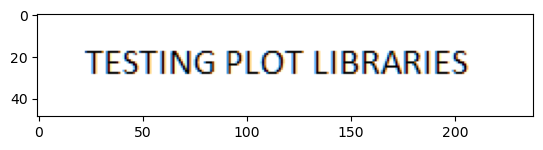

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
image = cv2.imread('C:/datasets/test.png')
plt.imshow(image)
plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

batch_size_train = 128
batch_size_test = 128

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5), (0.5))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5), (0.5))
                             ])),
  batch_size=batch_size_test, shuffle=True)

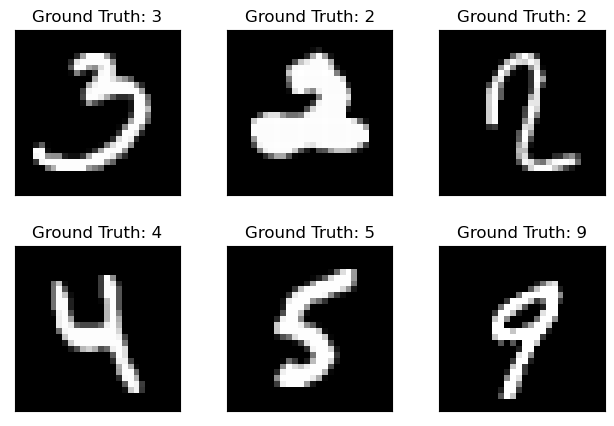

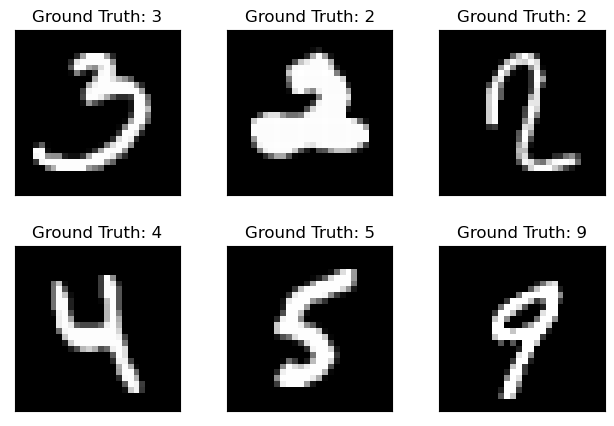

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
W = 28
F = 5
P = 2
S = 1
output_volume = ((W-F+2*P)/S+1 ); output_volume

28.0

In [6]:
img, lbl = next(iter(train_loader))

In [7]:
img.shape

torch.Size([128, 1, 28, 28])

In [68]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1,20,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(20,40,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(40,60,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU()
        )
        
        #latent space
        self.embedding = nn.Sequential(
            nn.Linear(60*4*4, 512),
            nn.LeakyReLU(),
            nn.Linear(512,144)
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 60,kernel_size=3,stride=2,padding=5),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(60, 40,kernel_size=4,stride=3,padding=6),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(40, 20,kernel_size=5,stride=1,padding=5),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 1,kernel_size=5,stride=1,padding=2)
        )

    def forward(self, x):
#         encoded = self.encoder(x)
#         x = encoded.view(-1,60*4*4) 
#         embedding = self.embedding(x)
#         x = embedding.view(-1,1,12,12)
        x = x.view(-1,1,12,12)
        decoded = self.decoder(x)
        return decoded 

model = AutoEncoder().cuda()
# print(model)
# print(model(img.cuda())[0].shape)

In [16]:
from torch.nn import MSELoss
import torch.optim as optim

In [36]:
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

train_loss_min = 2.978473 # track change in validation loss

for epoch in tqdm(range(1, n_epochs+1), desc="Epochs"):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    counter = 0
    model.train()
    for data, target in tqdm(train_loader):
        counter += 1
        data = data.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)[0]
        # calculate the batch loss
        loss = criterion(output, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/counter
    if train_loss > 100:
        print('gradient explosion')
        break
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))
    
    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        print('Similarity loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        train_loss_min,
        train_loss))
        torch.save(model.state_dict(), 'model_autoencoder.pt')
        train_loss_min = train_loss

In [69]:
model.load_state_dict(torch.load('model_autoencoder.pt'))

<All keys matched successfully>

In [45]:
vectors = []
for i in range(img.shape[0]):
    vectors.append((model(img[i].cuda())[1], lbl[i]))

In [55]:
vectors[0][0].shape

torch.Size([1, 144])

In [ ]:
model(vectors[0][0].cuda())[0].shape

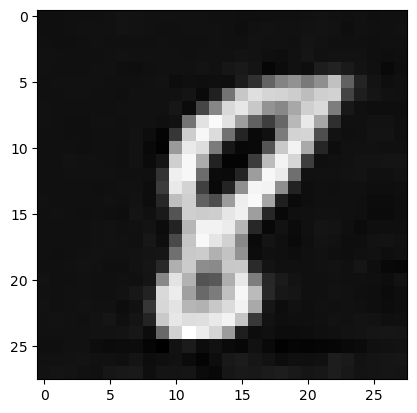

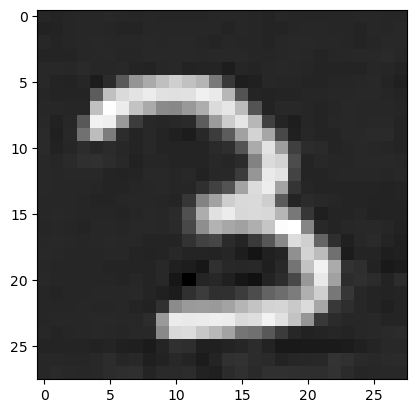

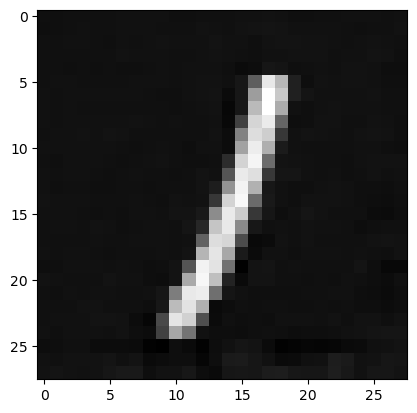

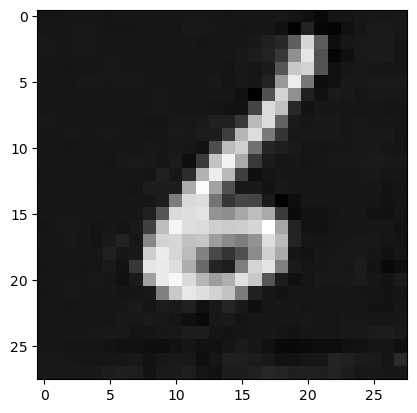

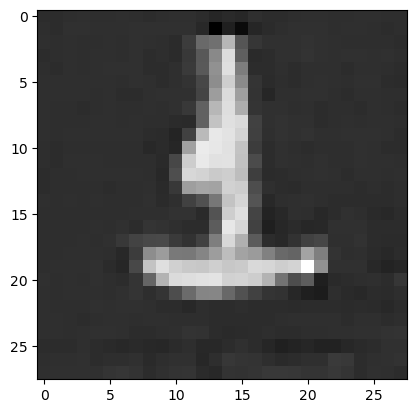

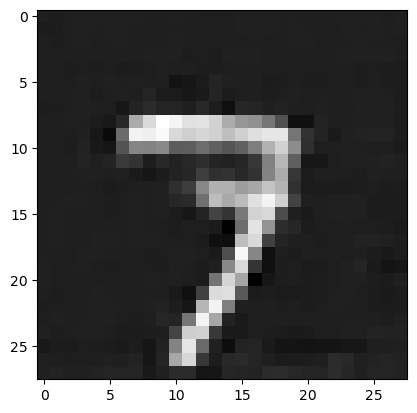

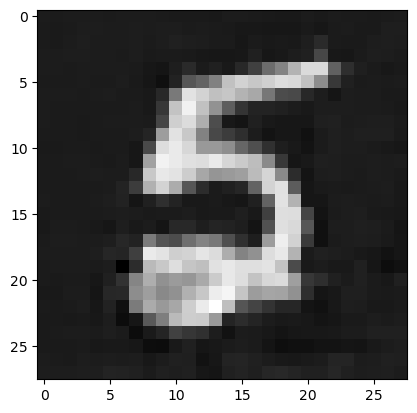

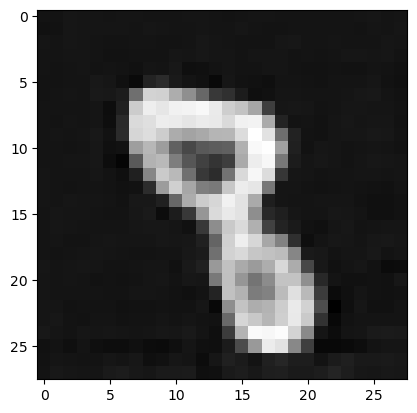

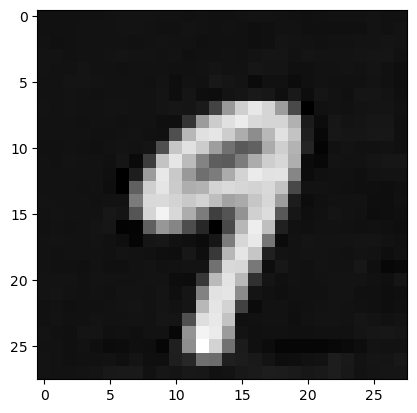

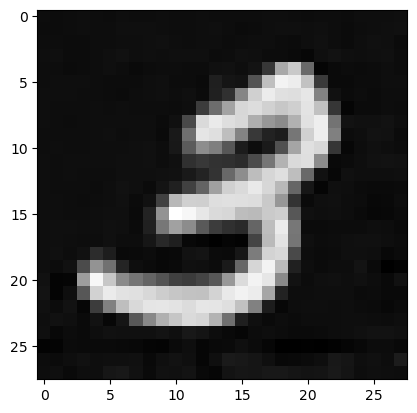

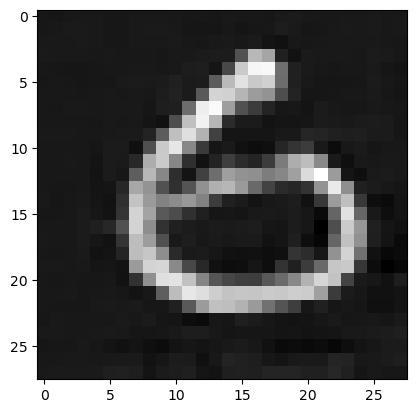

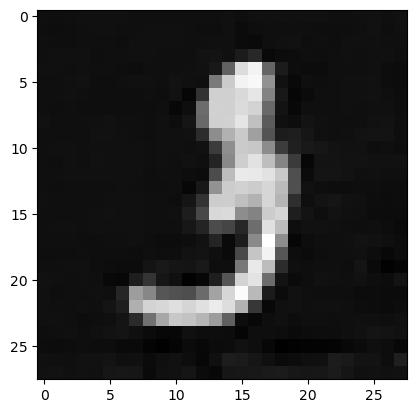

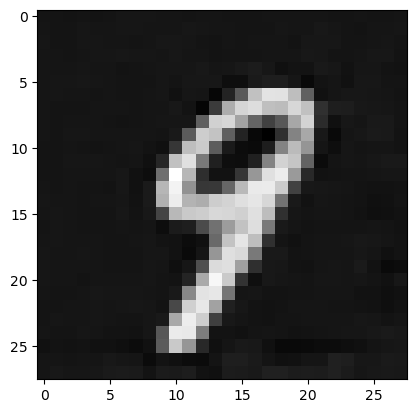

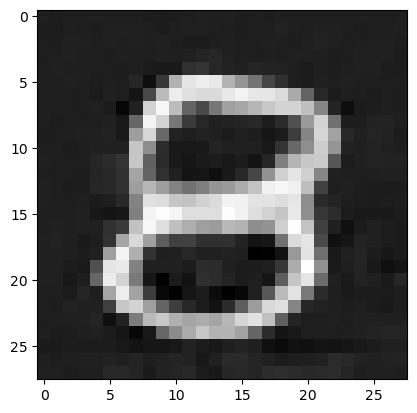

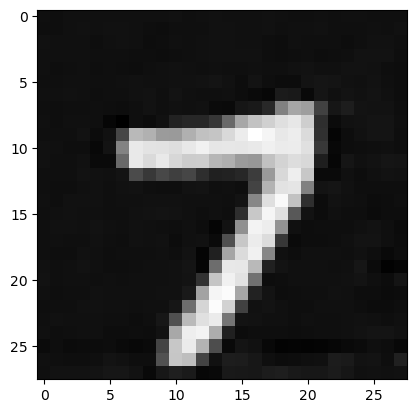

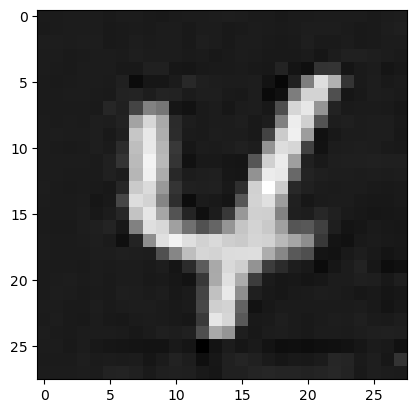

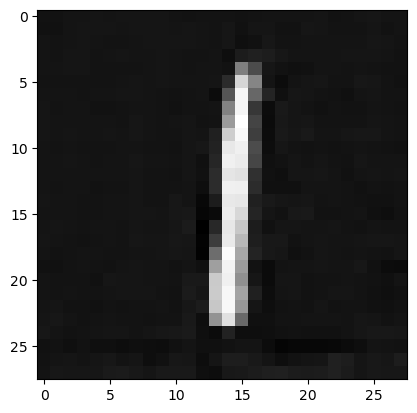

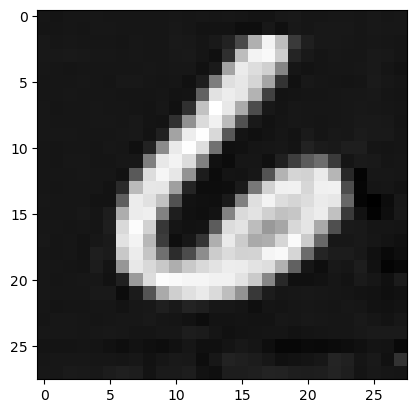

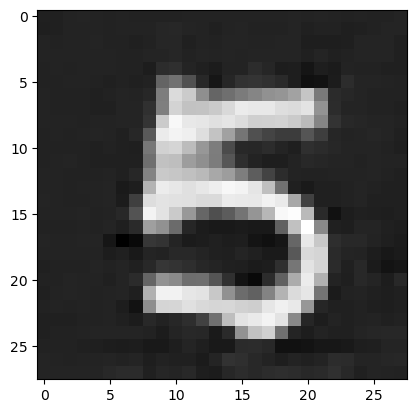

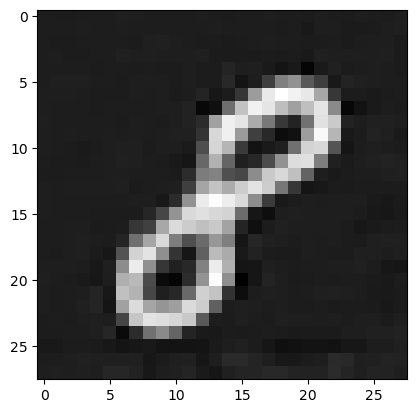

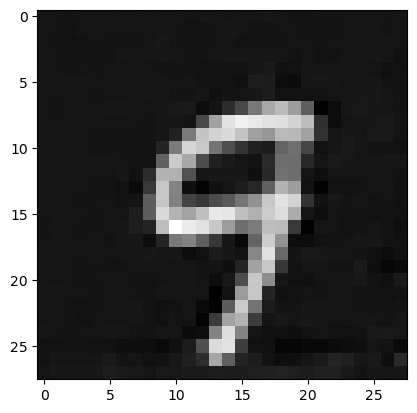

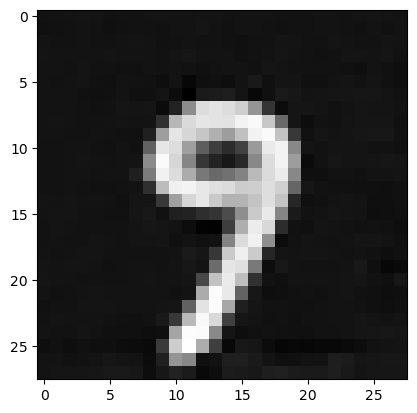

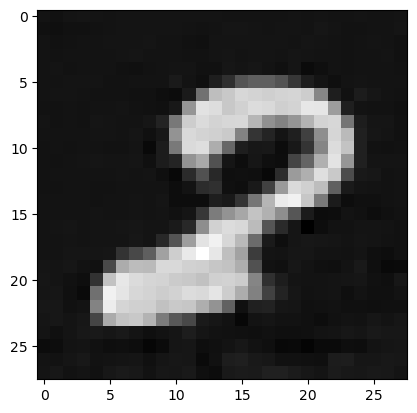

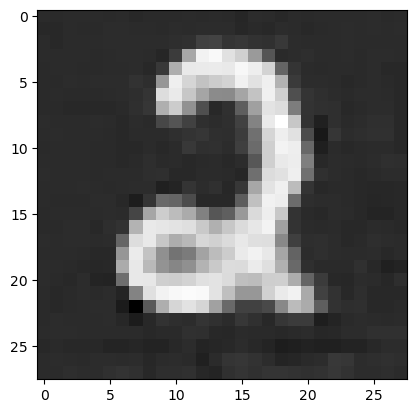

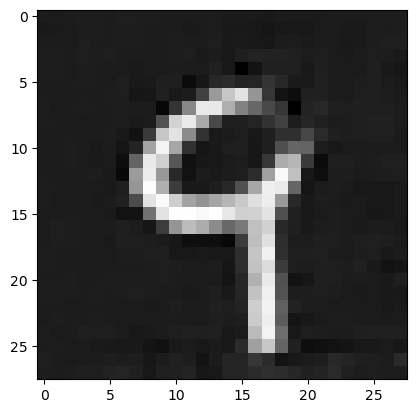

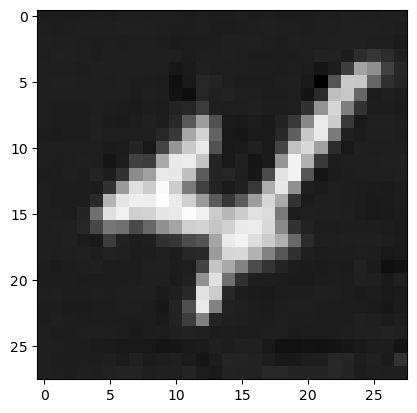

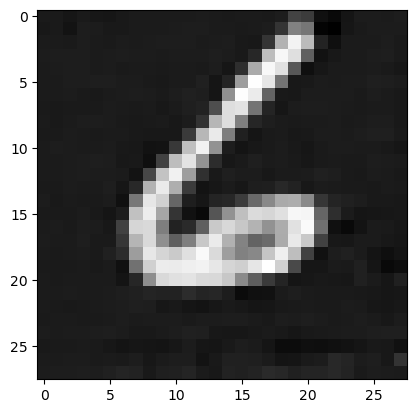

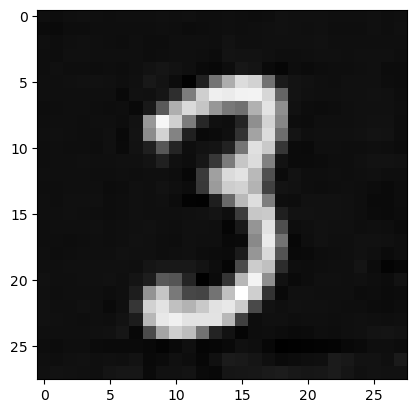

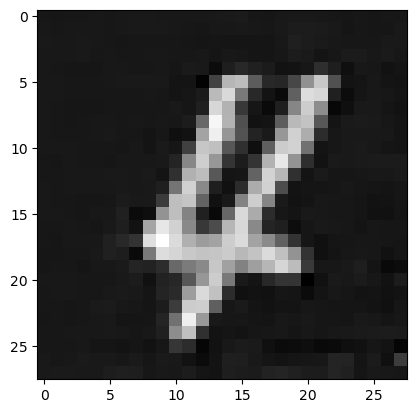

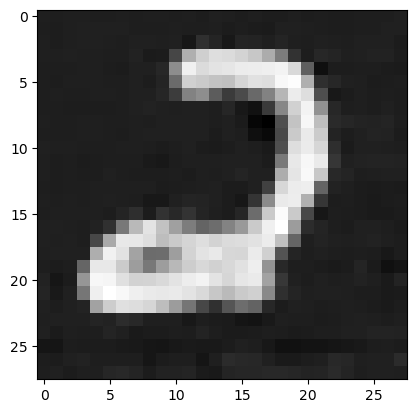

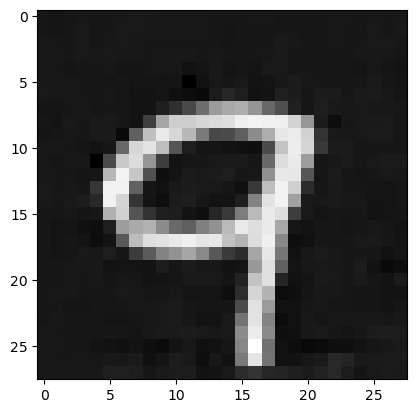

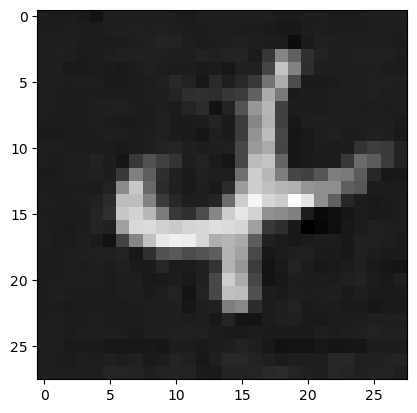

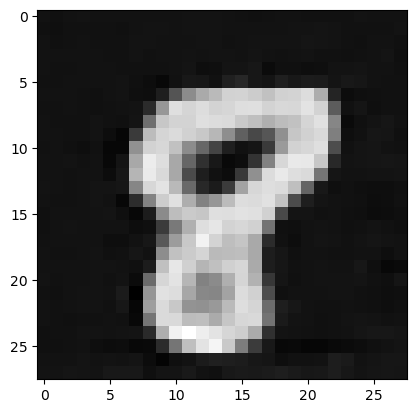

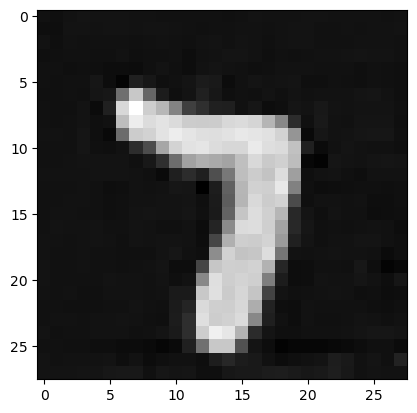

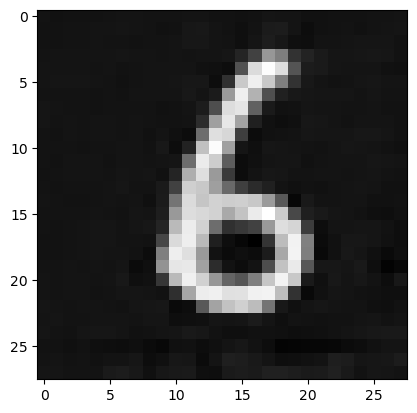

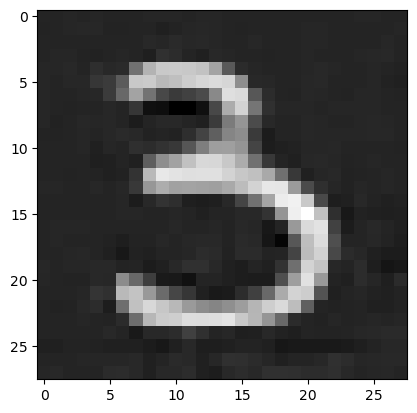

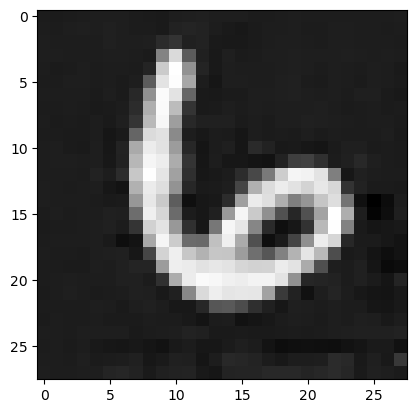

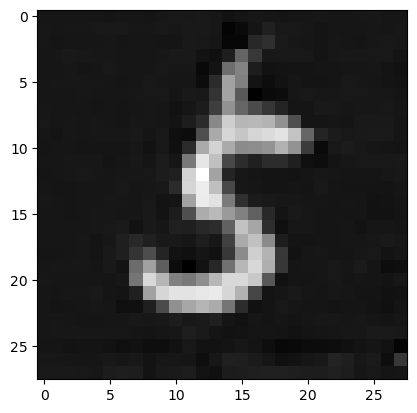

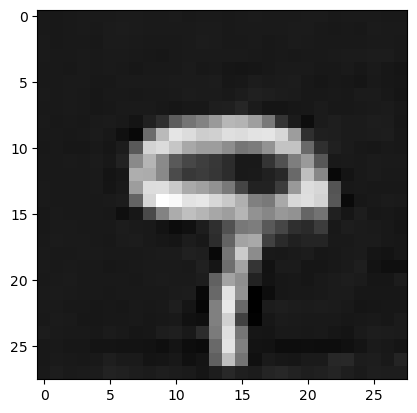

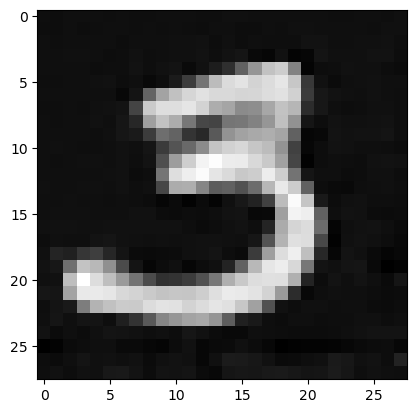

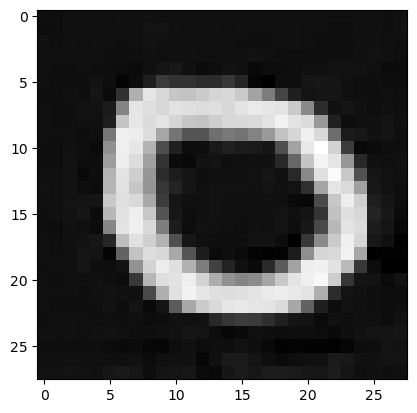

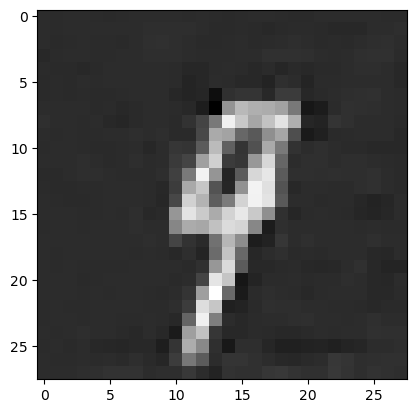

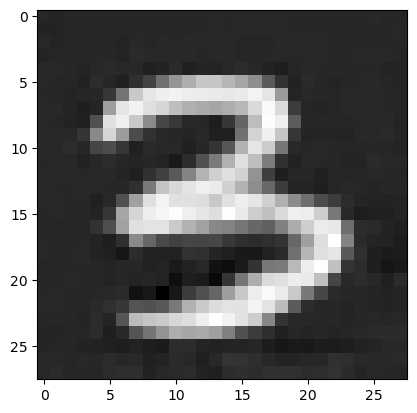

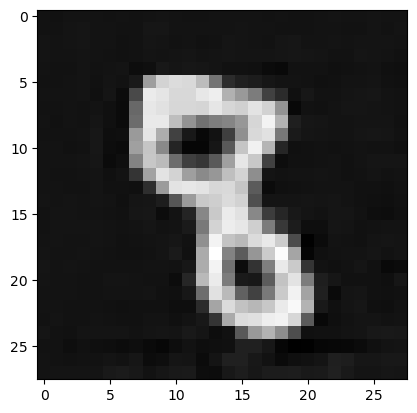

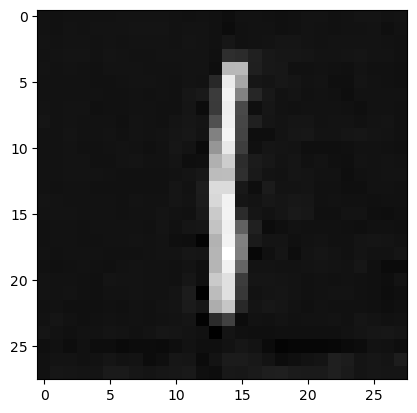

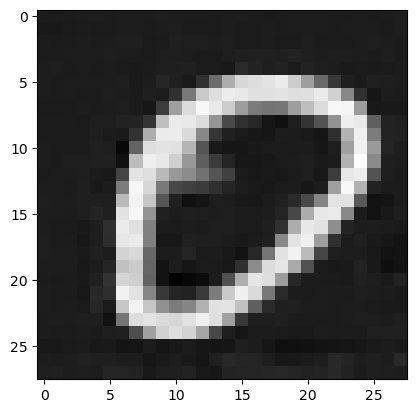

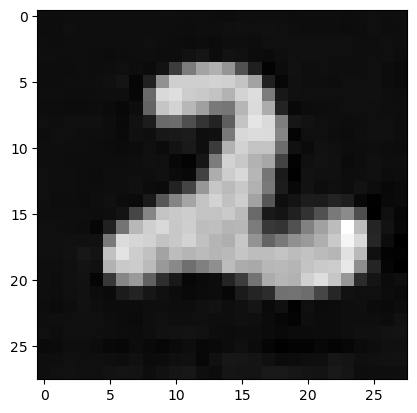

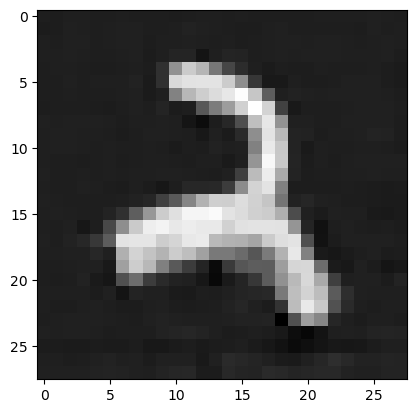

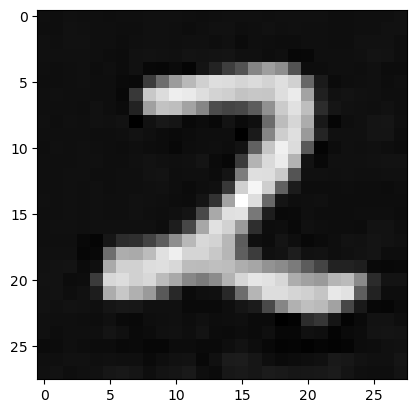

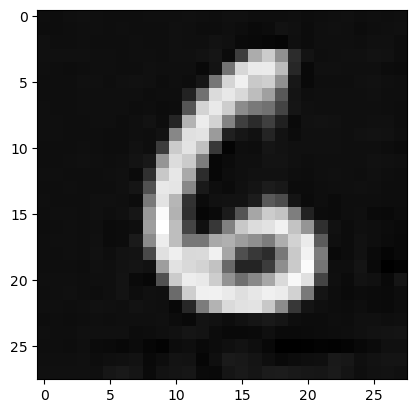

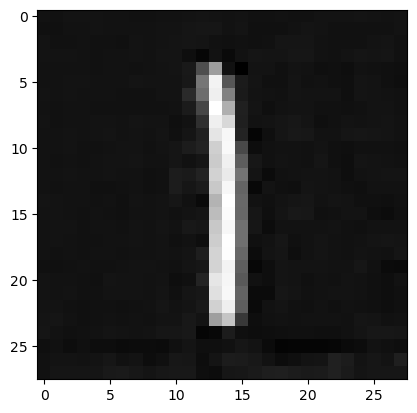

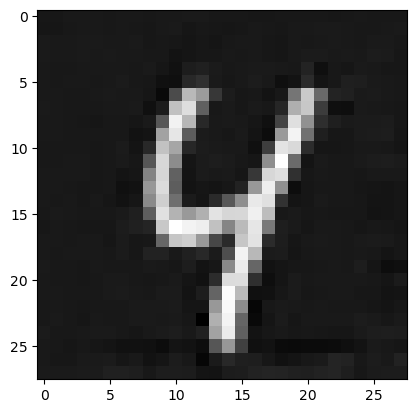

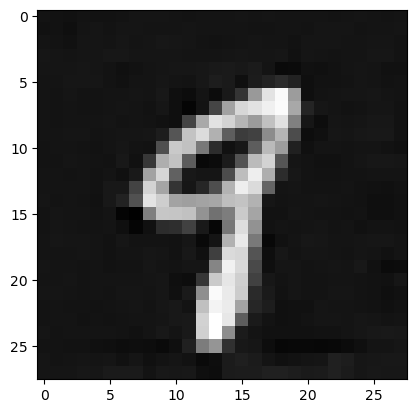

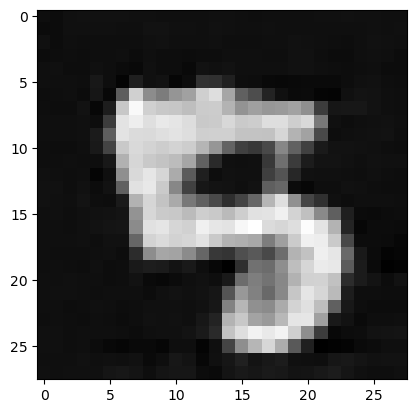

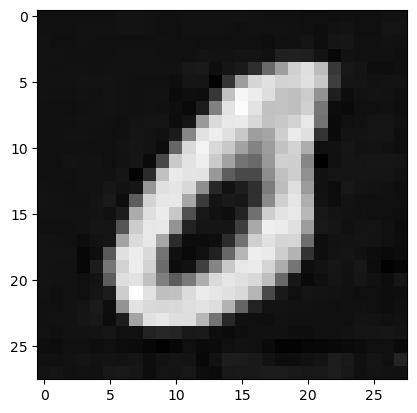

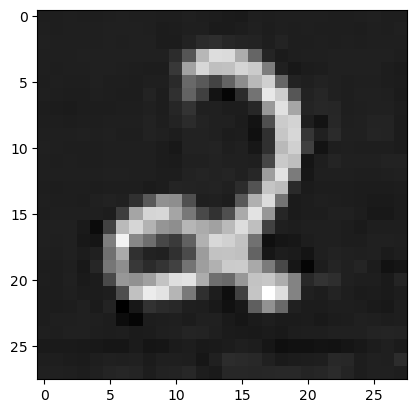

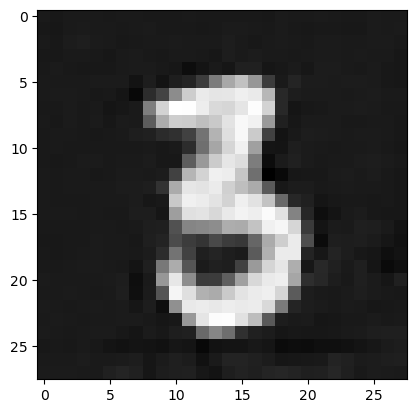

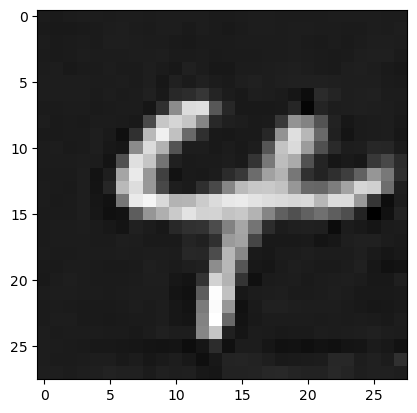

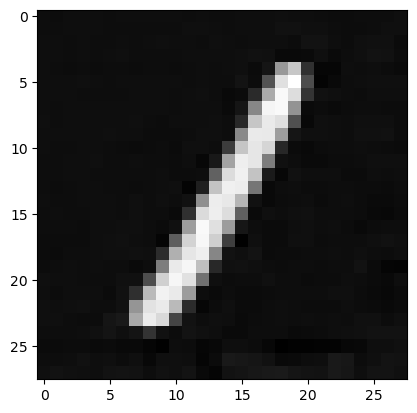

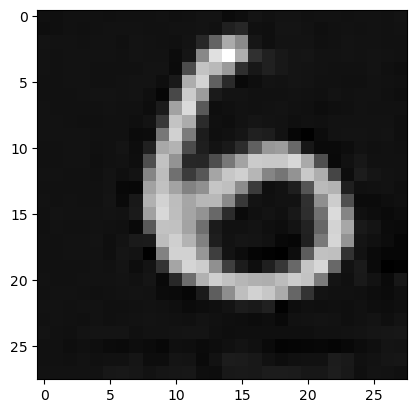

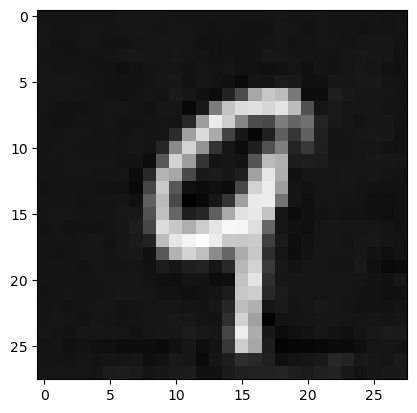

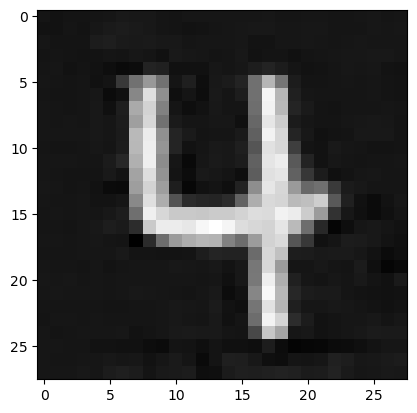

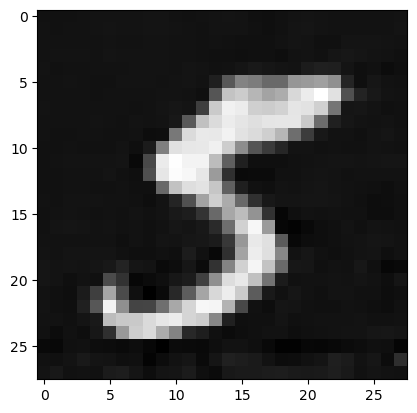

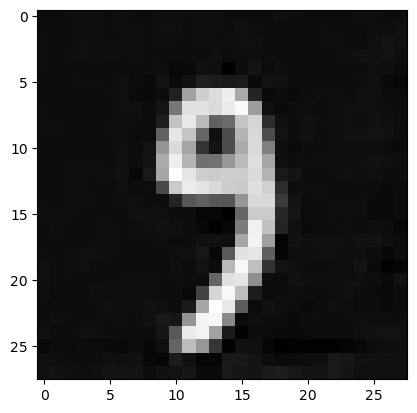

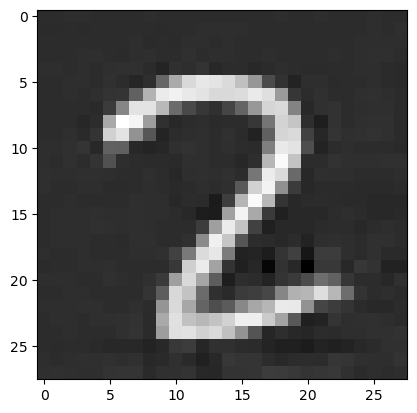

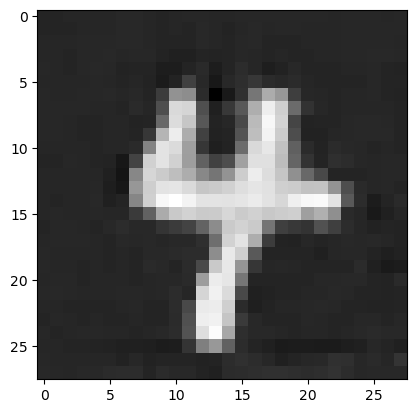

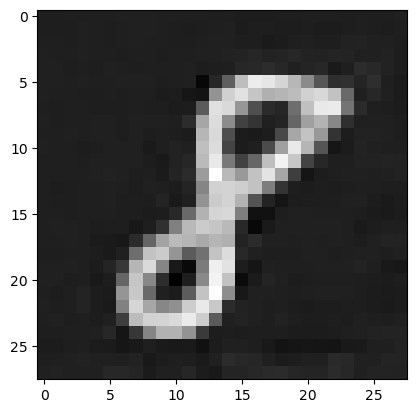

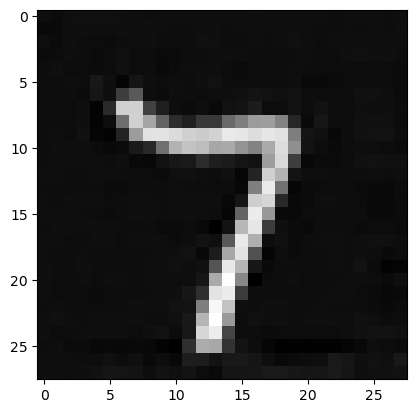

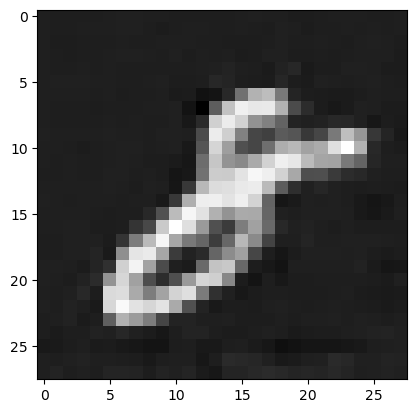

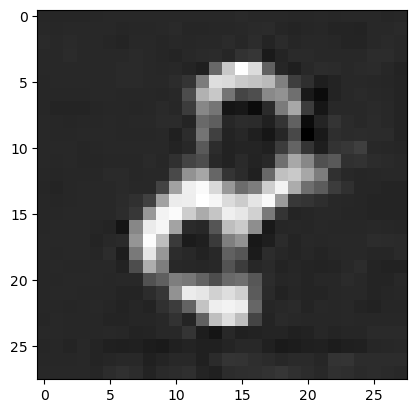

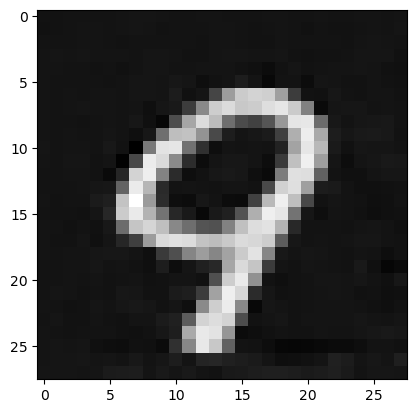

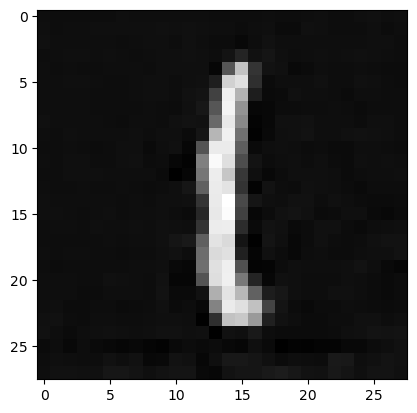

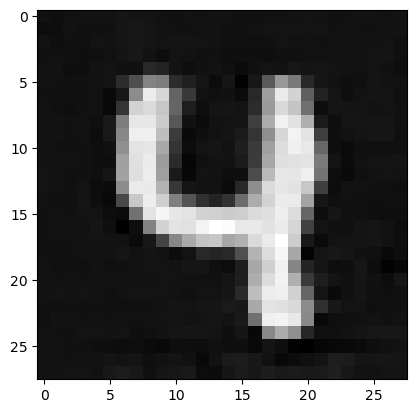

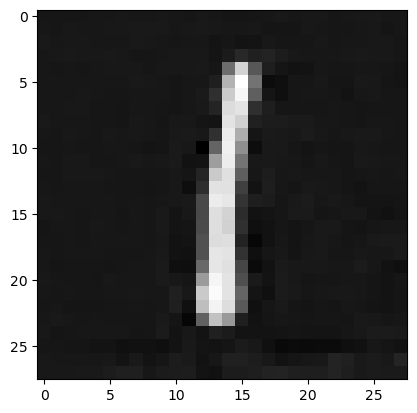

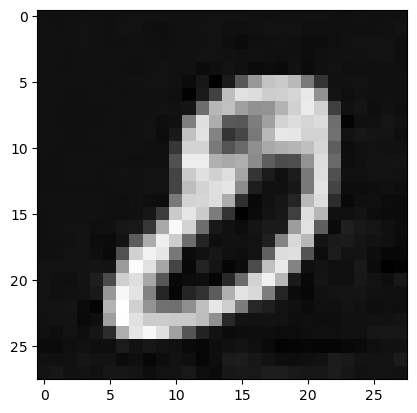

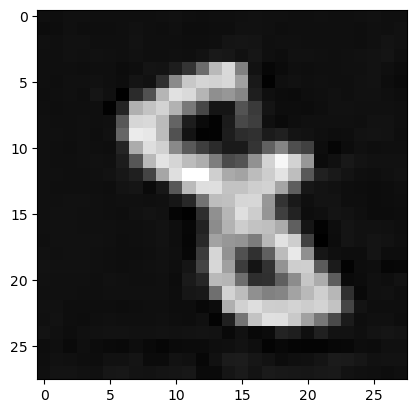

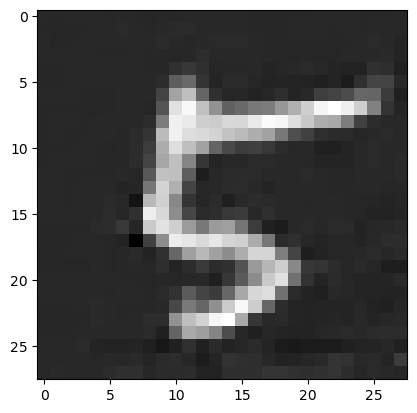

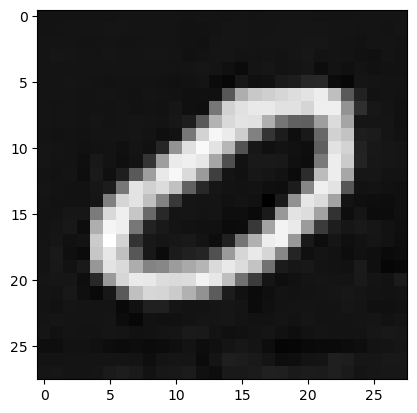

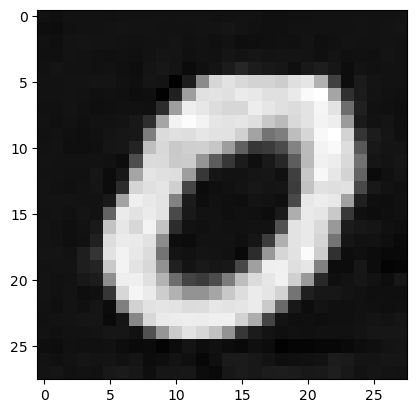

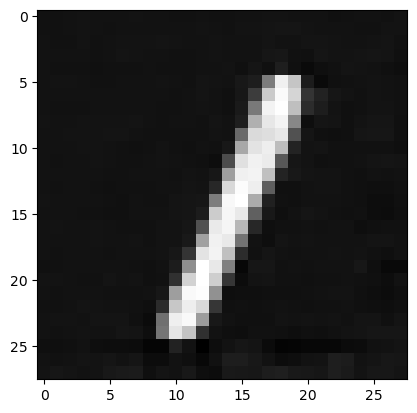

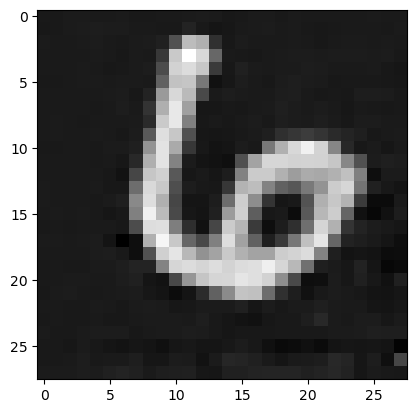

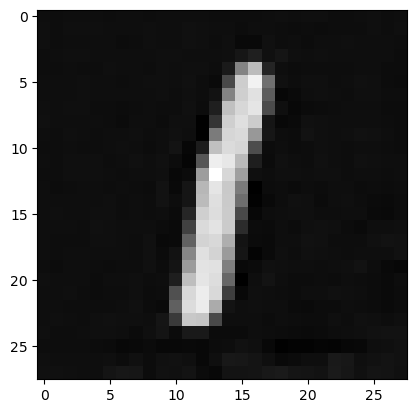

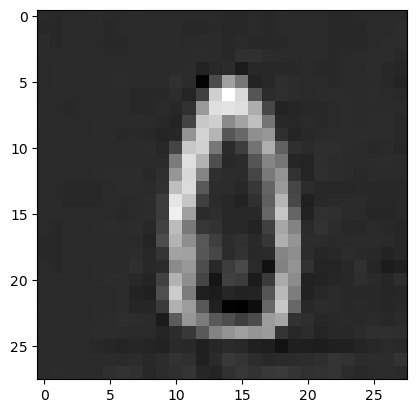

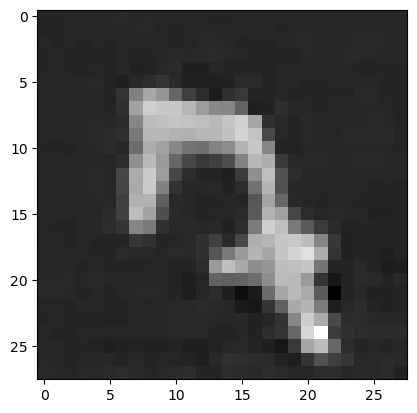

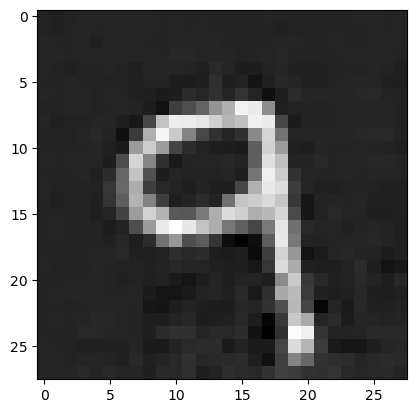

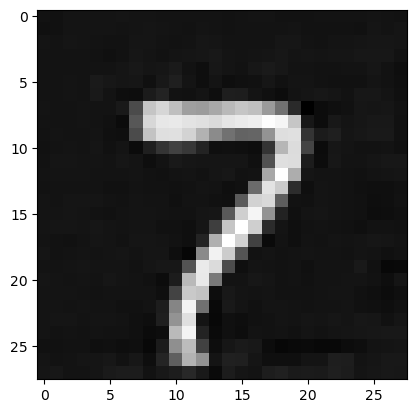

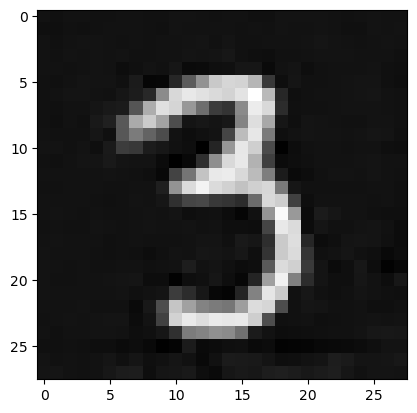

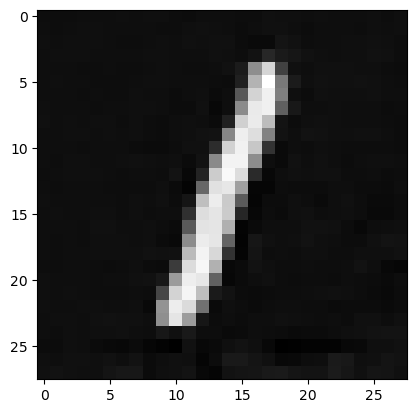

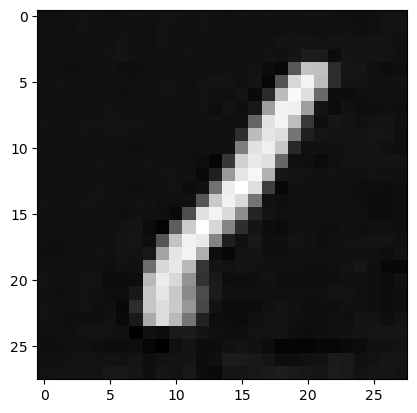

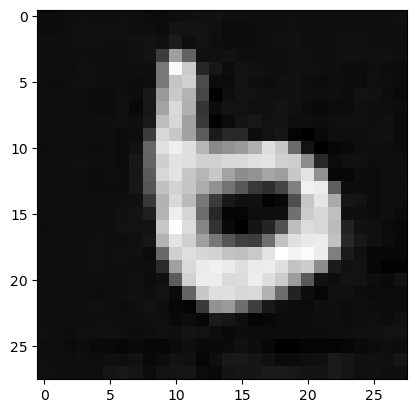

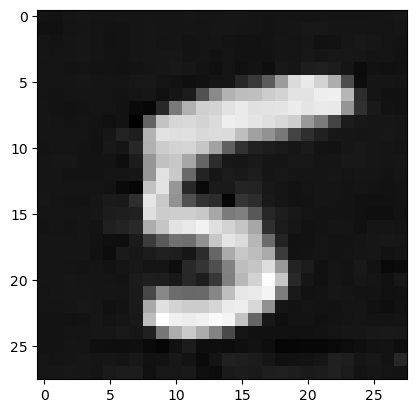

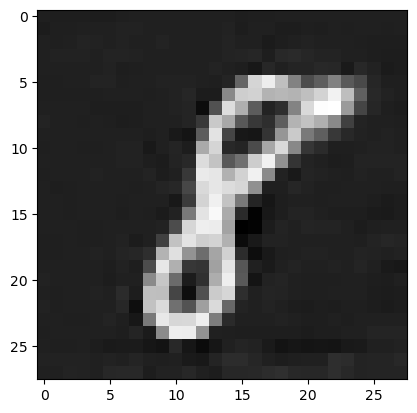

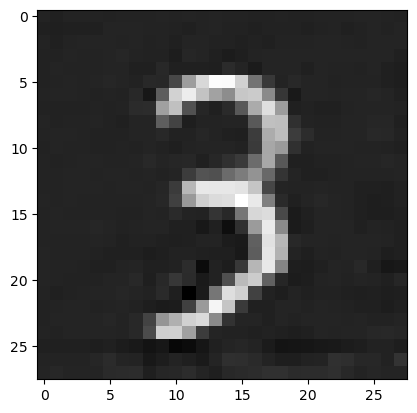

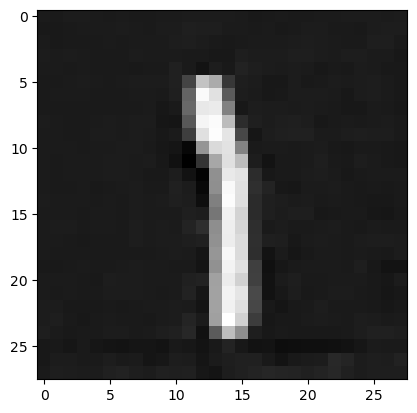

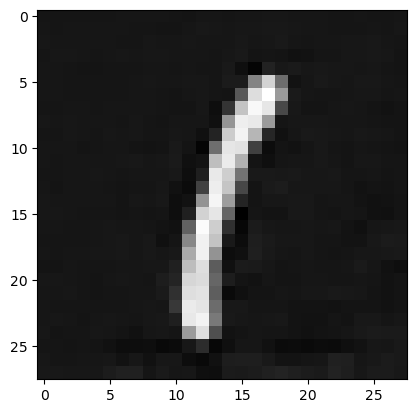

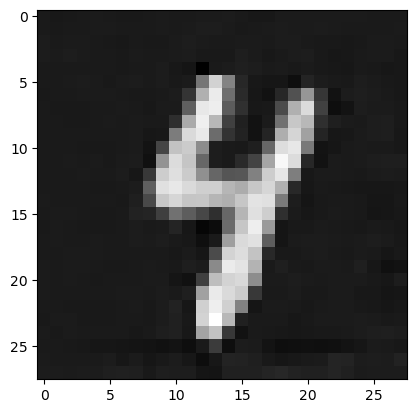

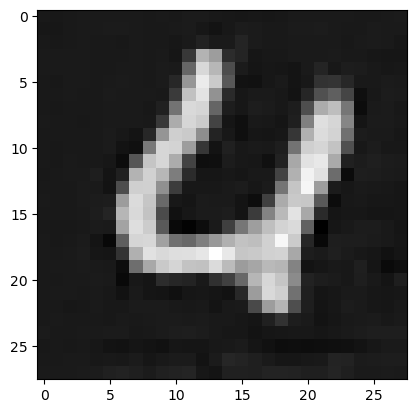

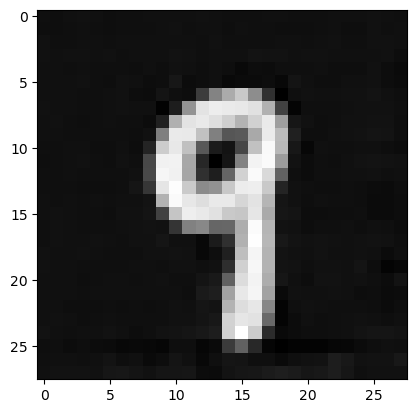

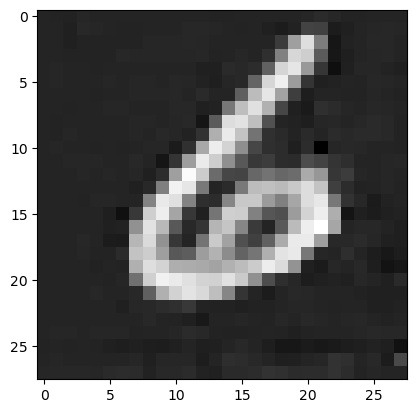

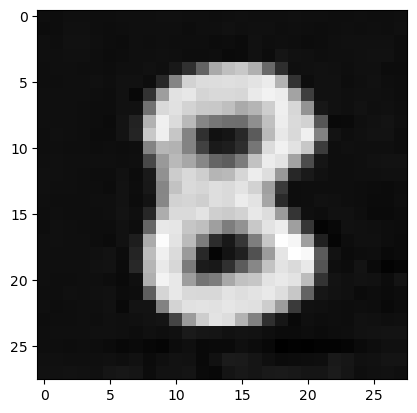

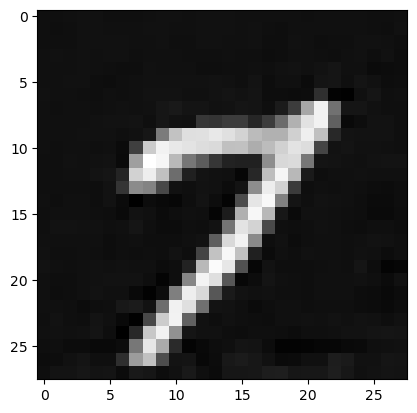

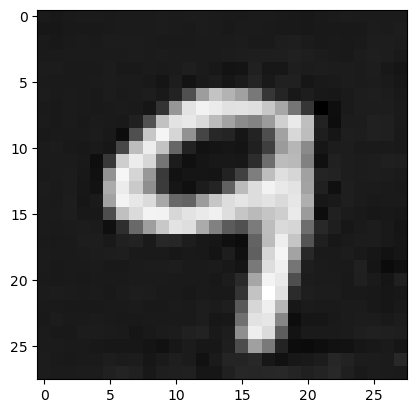

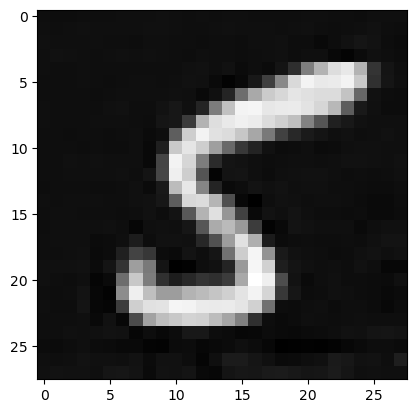

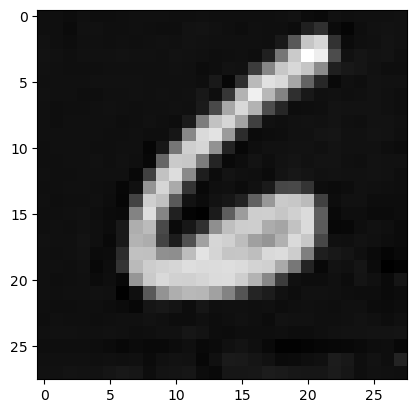

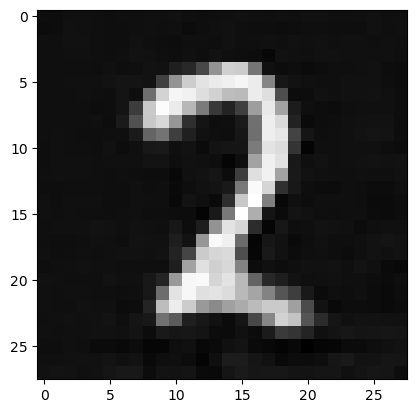

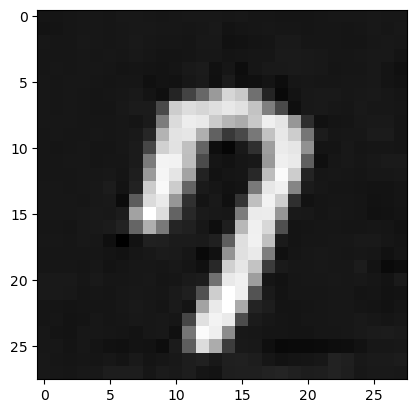

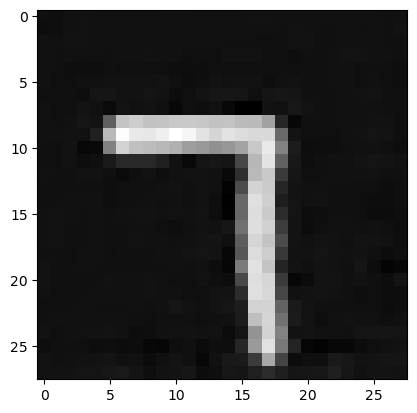

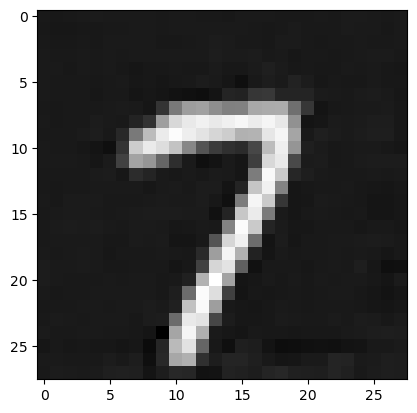

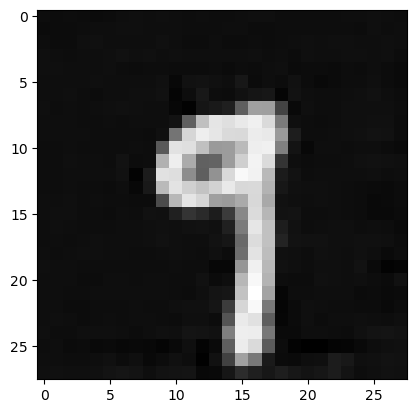

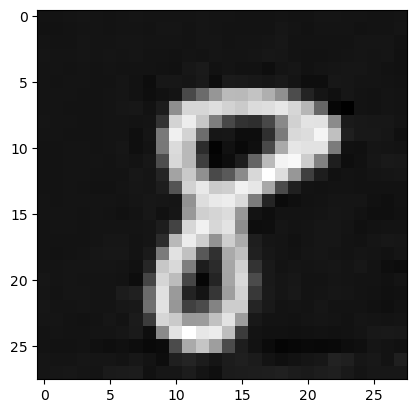

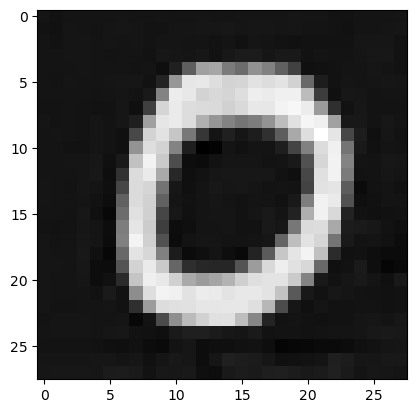

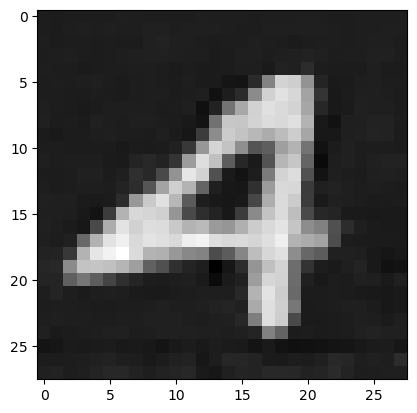

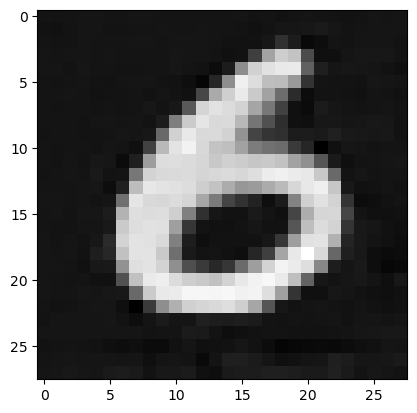

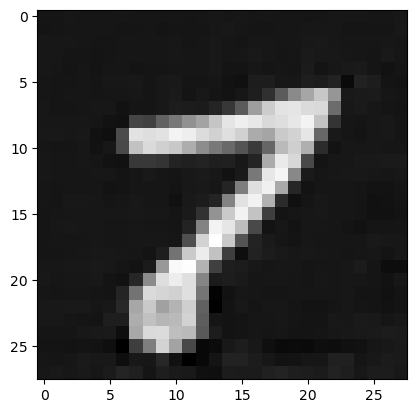

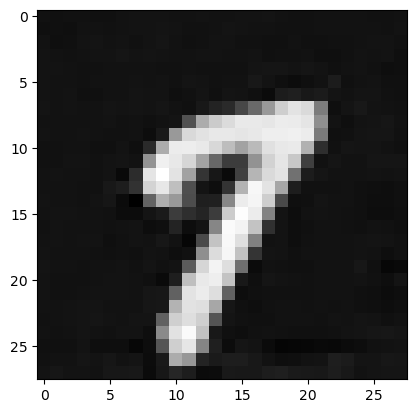

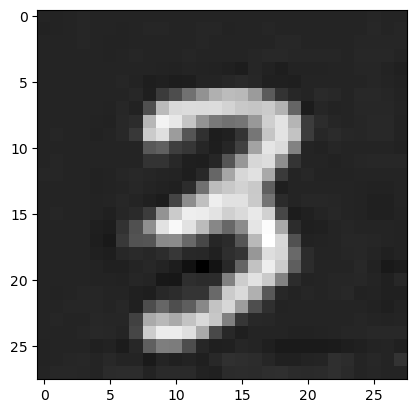

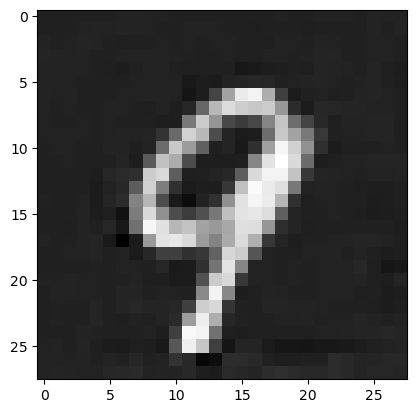

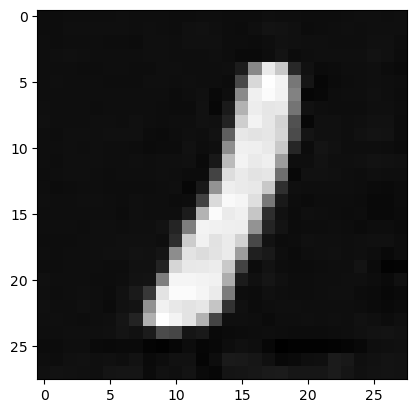

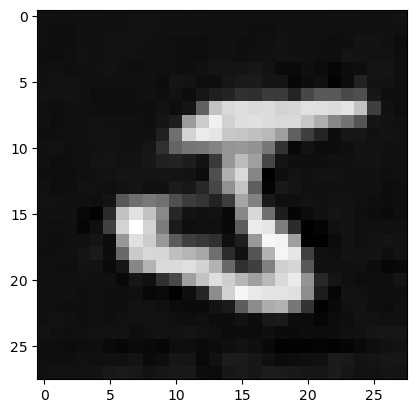

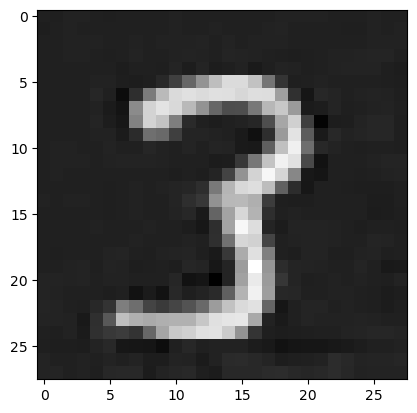

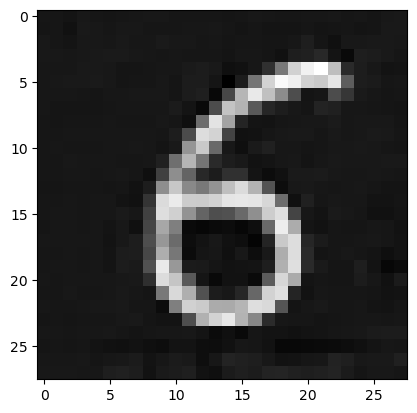

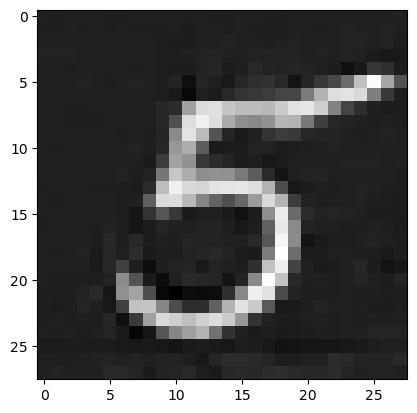

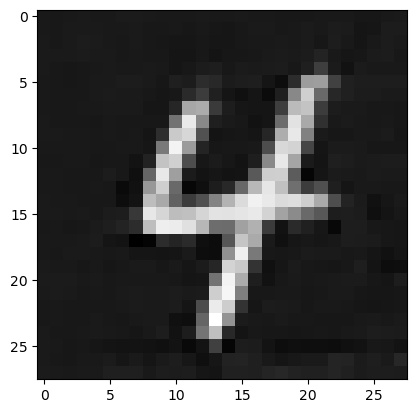

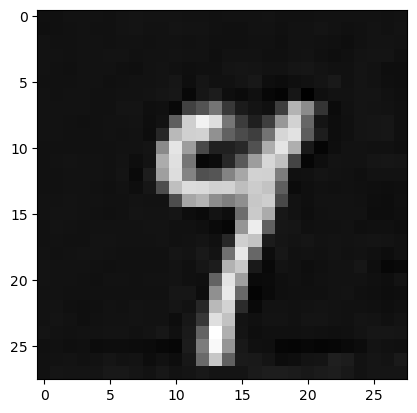

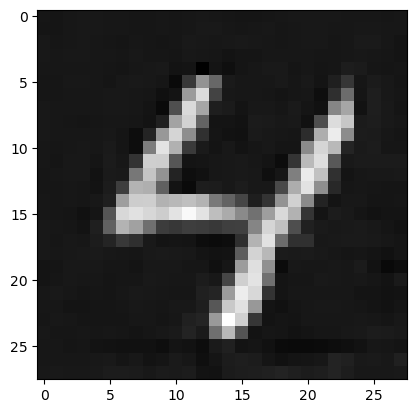

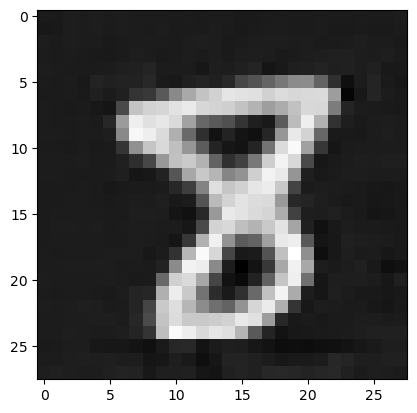

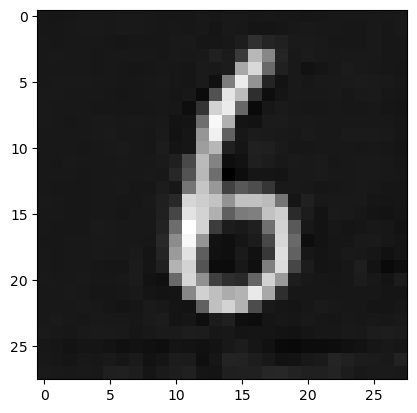

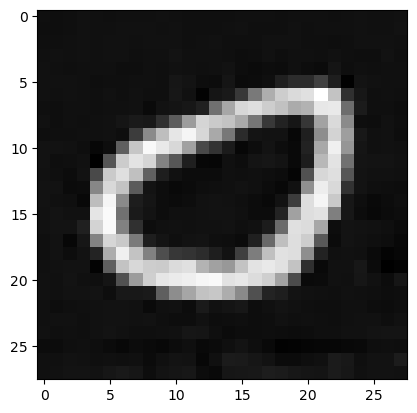

In [102]:
for i in range(len(vectors)):
    plt.imshow(model((vectors[i][0]).cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')
    plt.show()

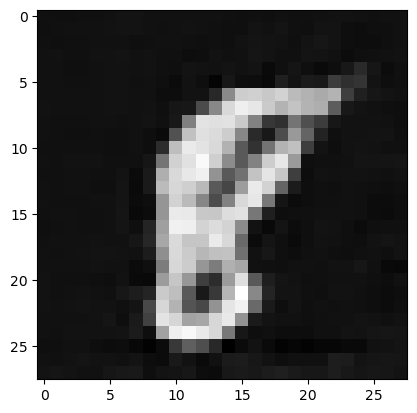

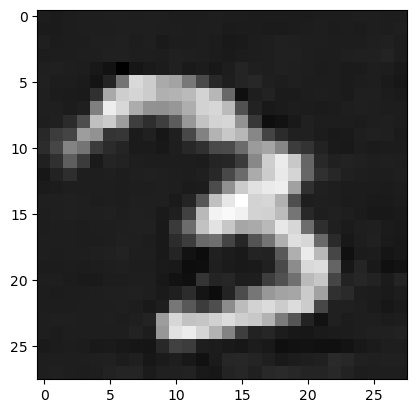

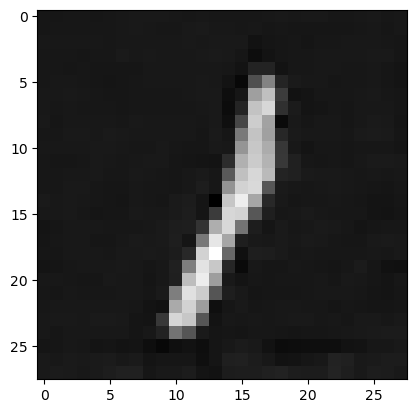

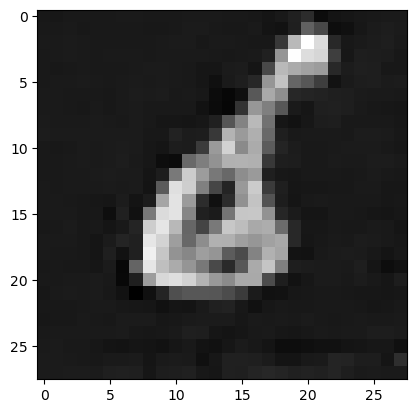

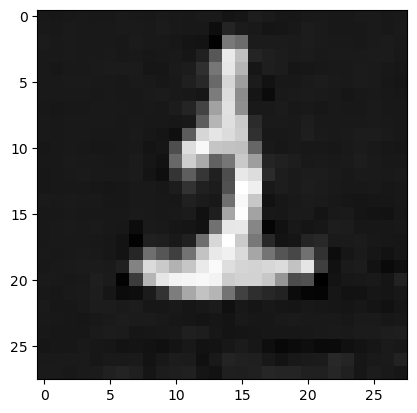

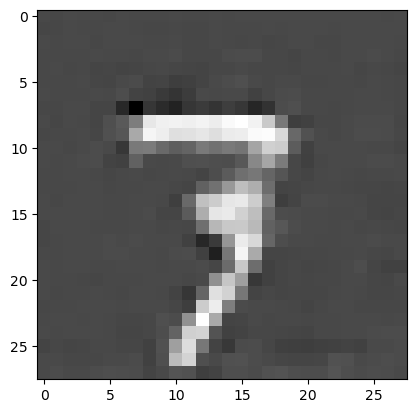

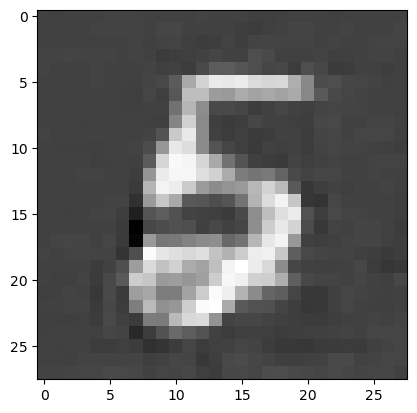

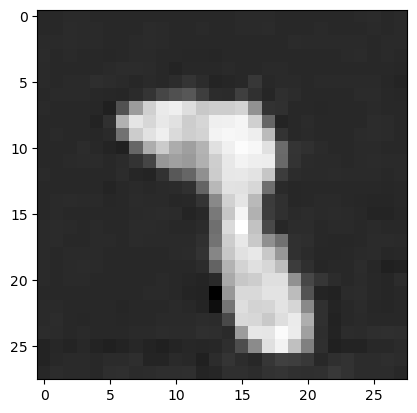

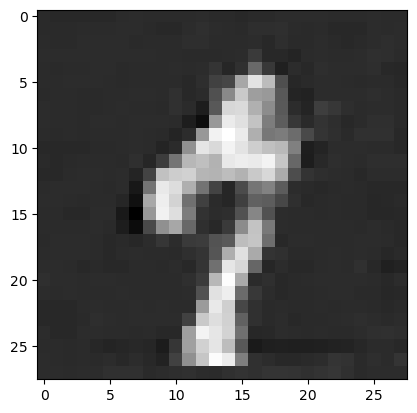

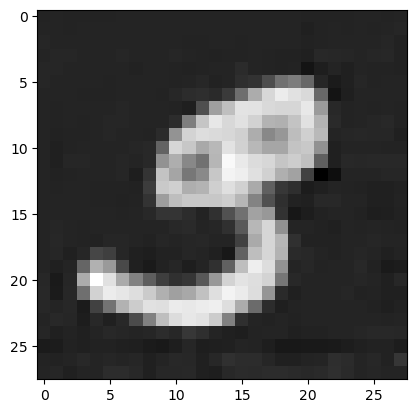

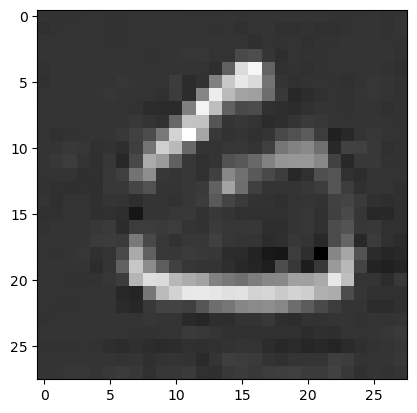

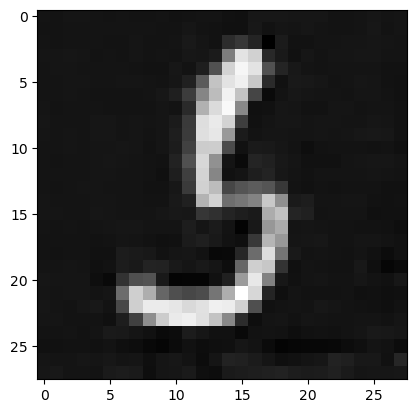

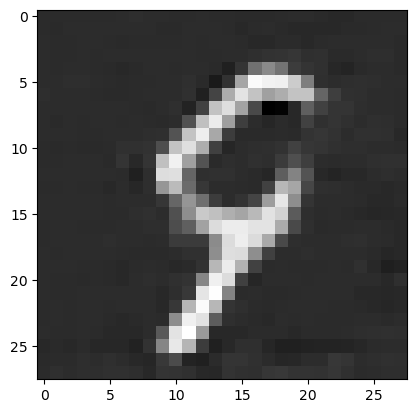

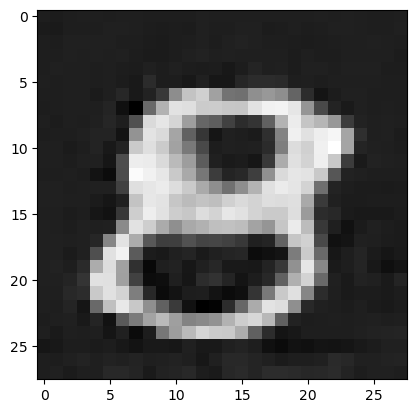

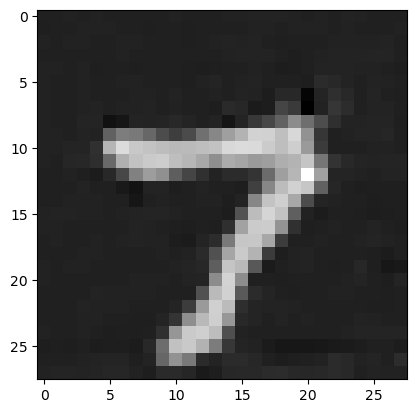

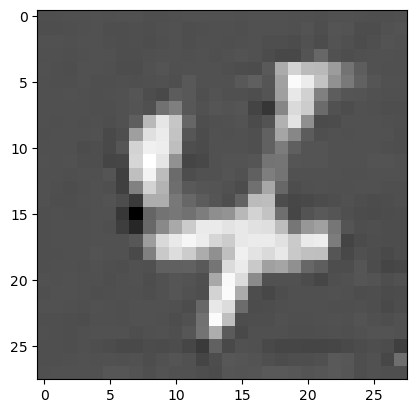

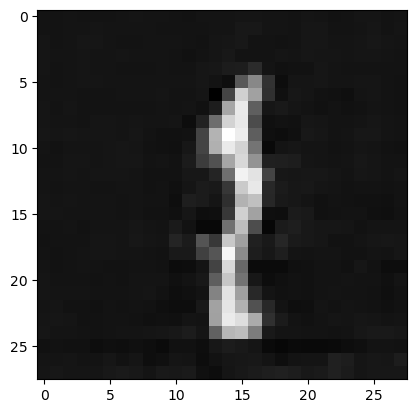

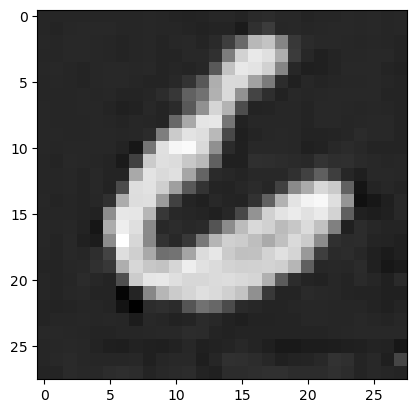

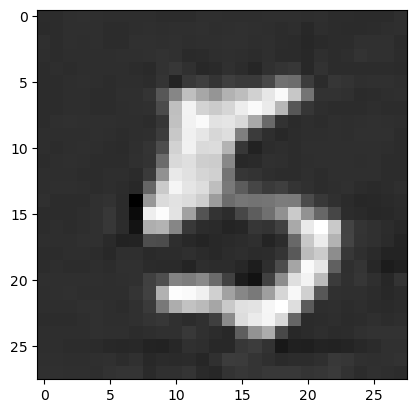

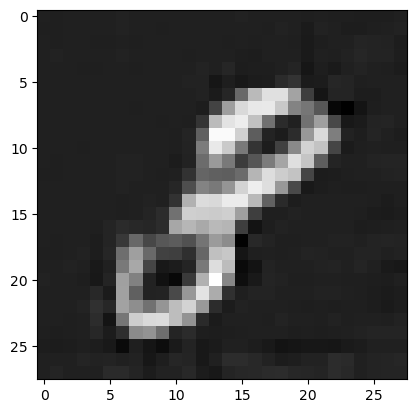

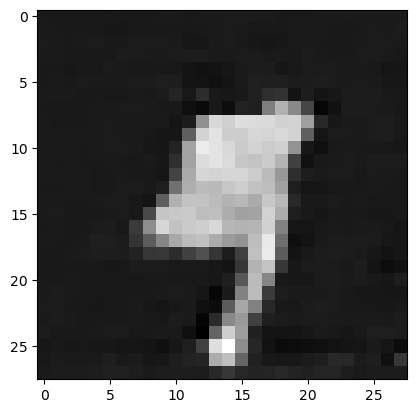

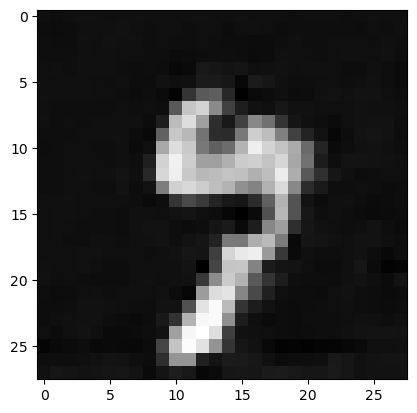

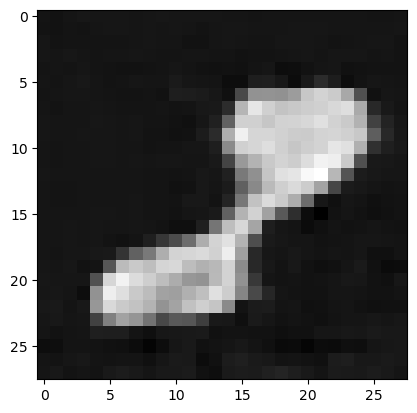

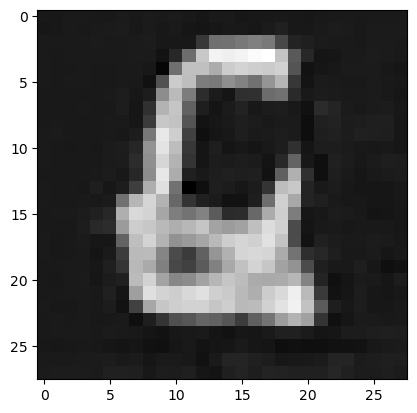

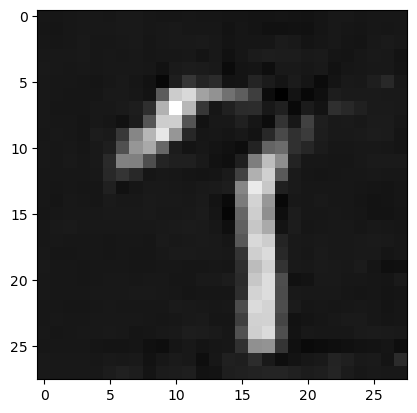

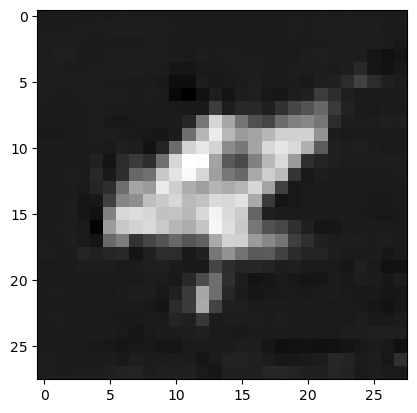

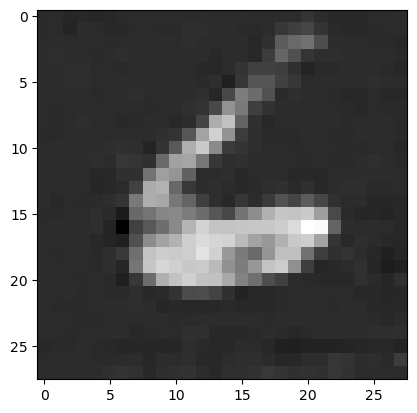

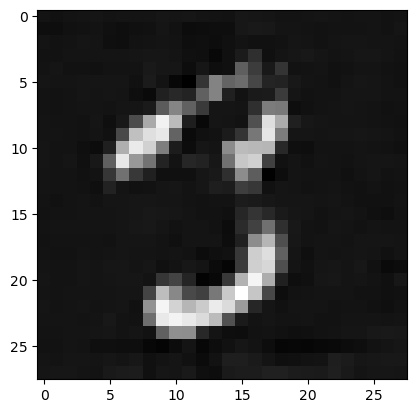

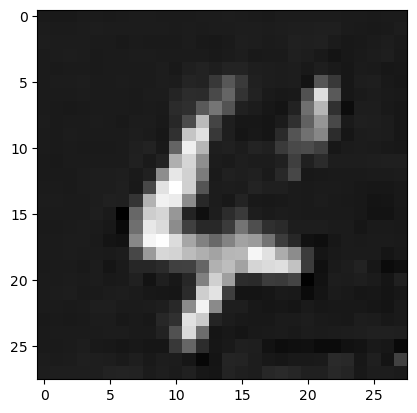

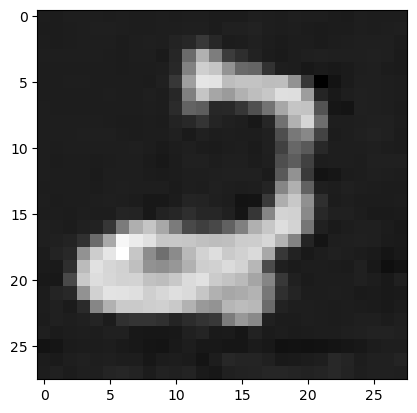

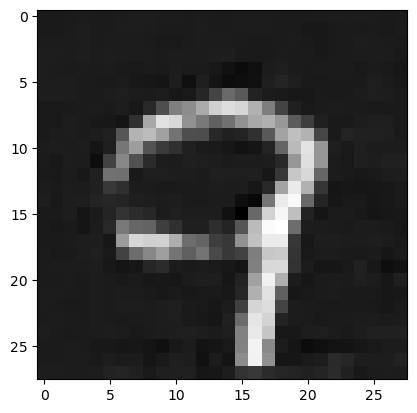

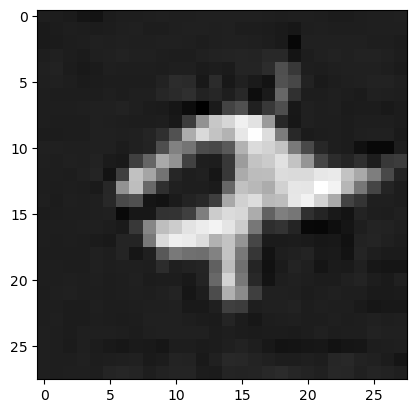

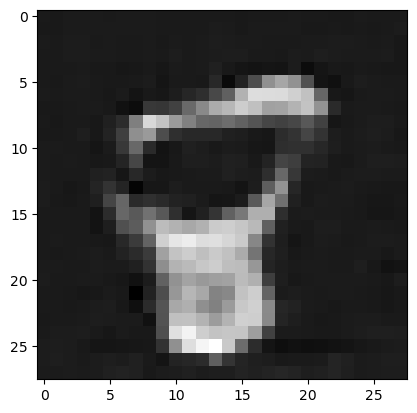

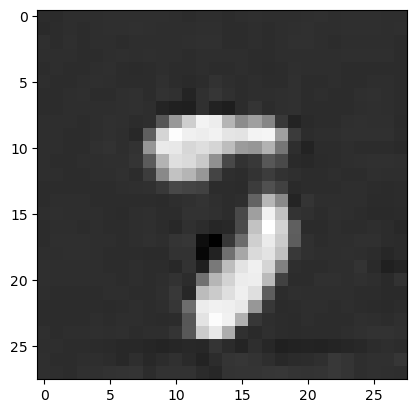

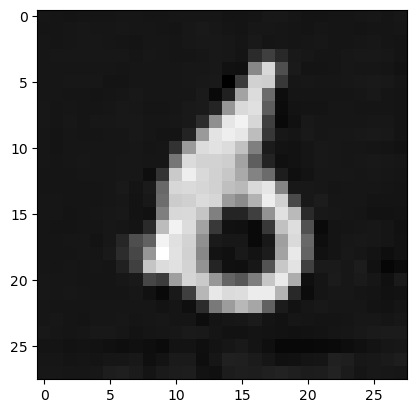

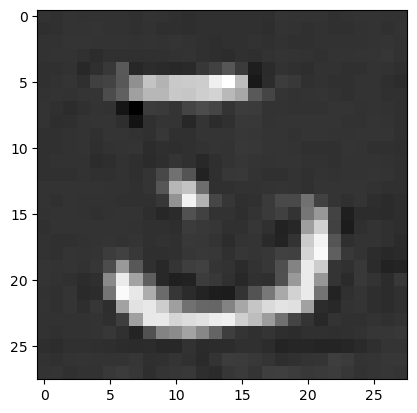

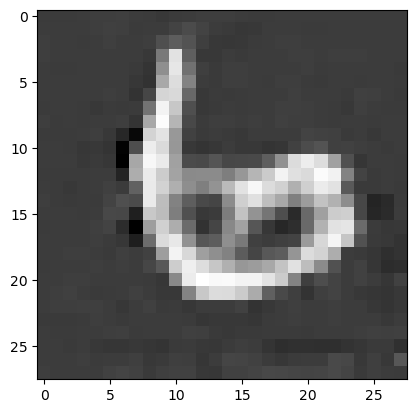

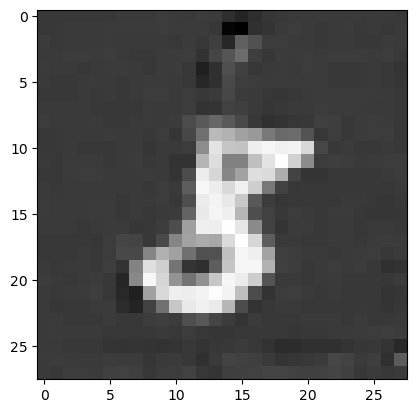

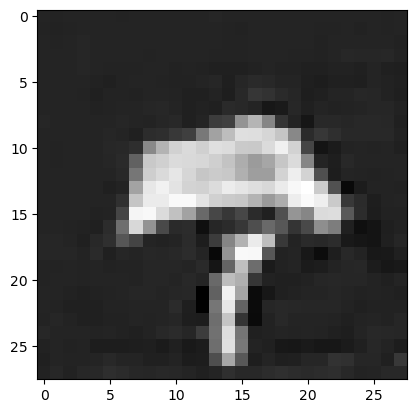

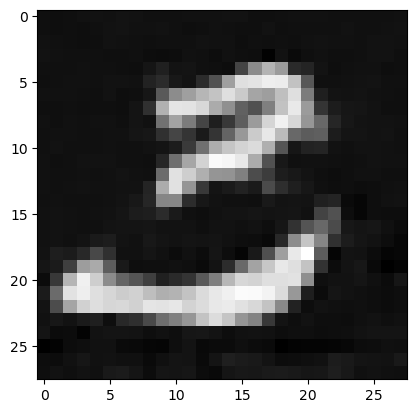

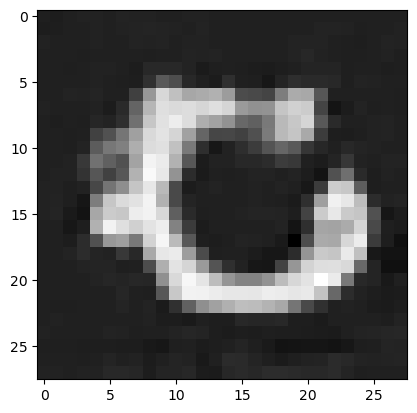

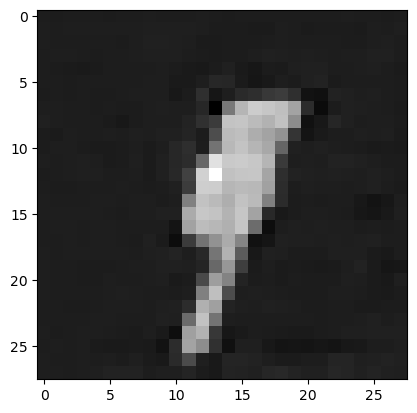

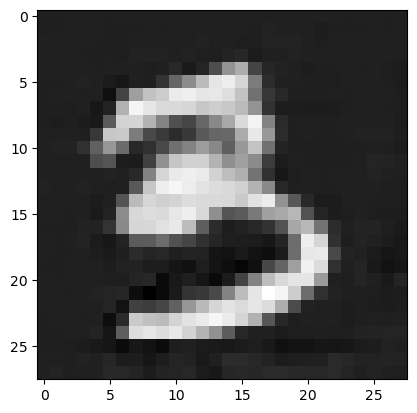

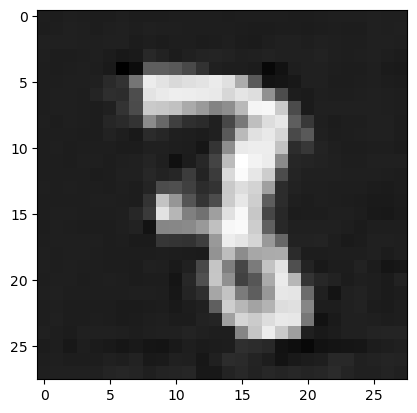

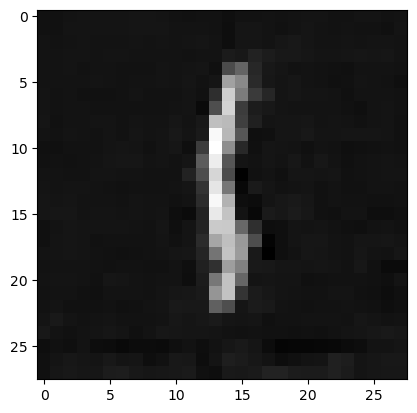

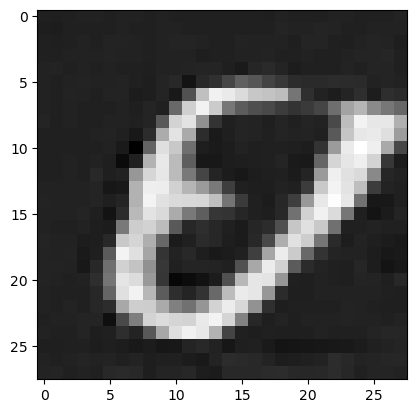

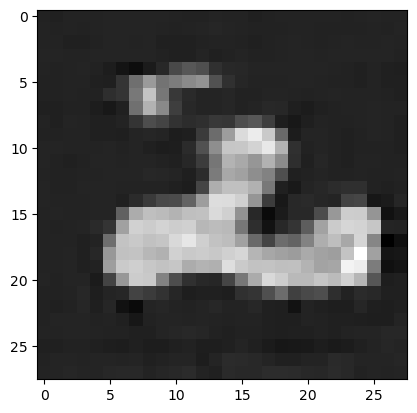

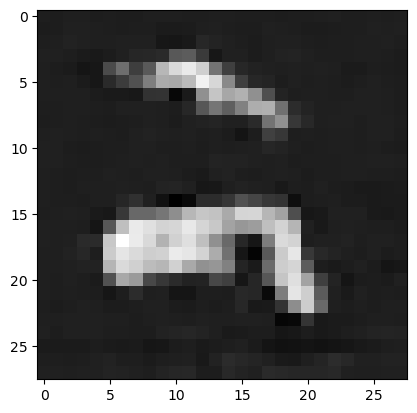

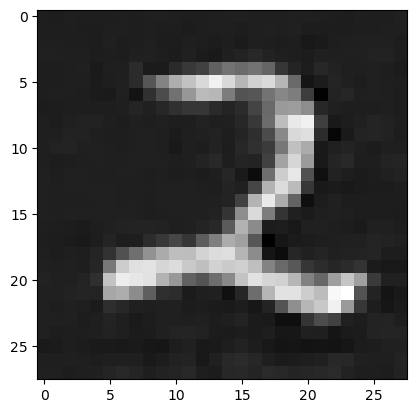

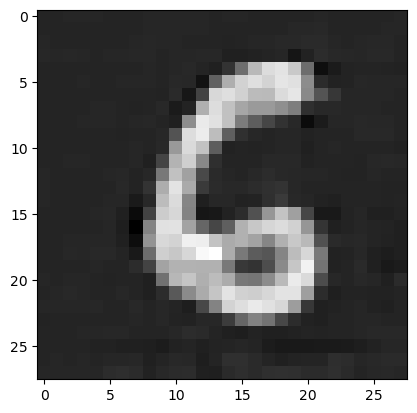

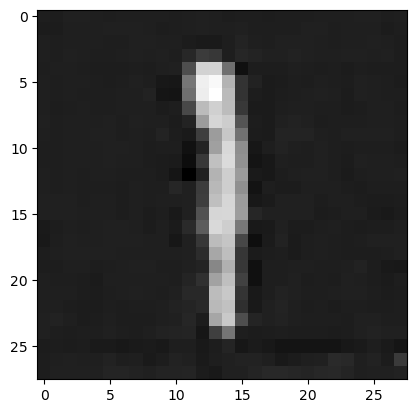

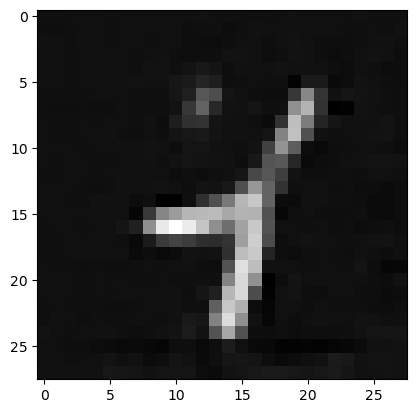

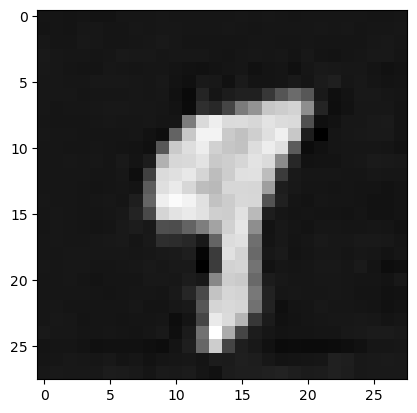

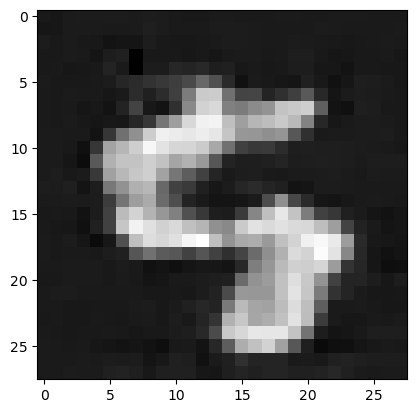

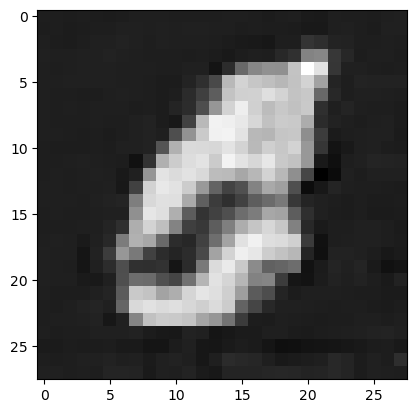

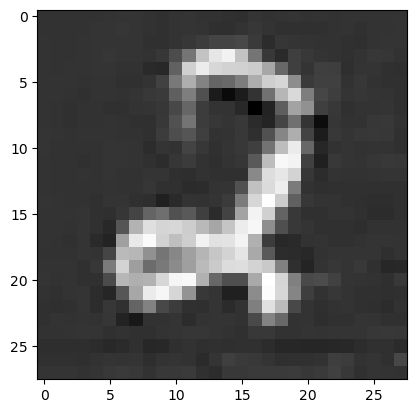

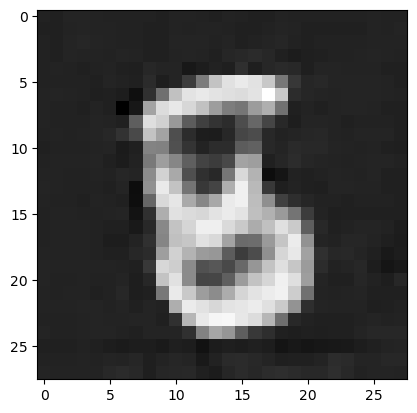

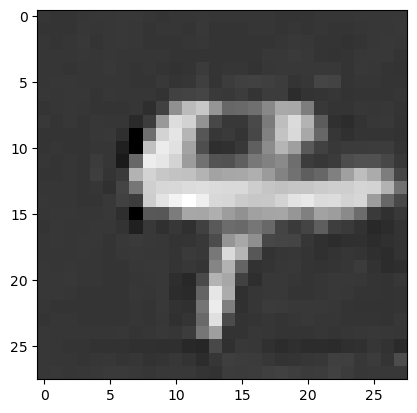

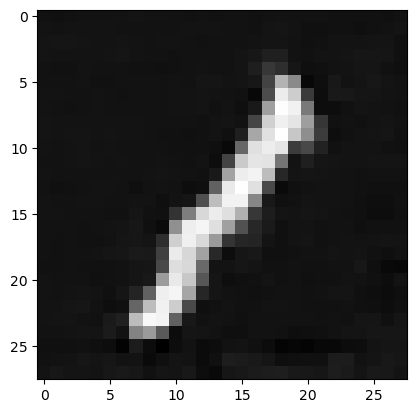

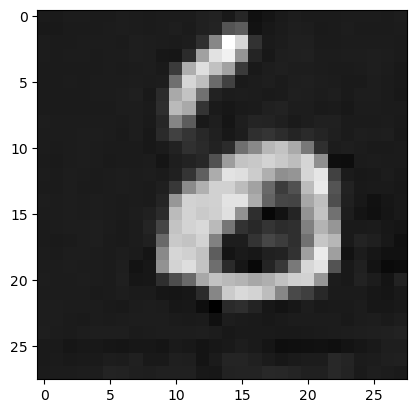

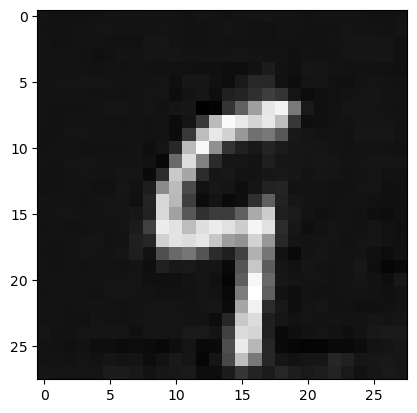

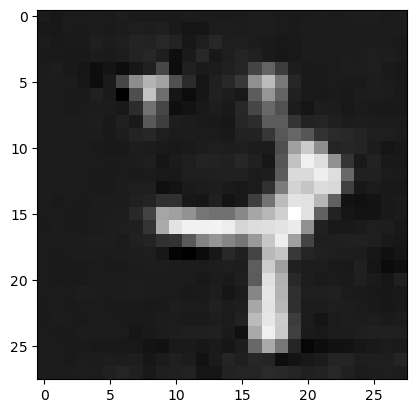

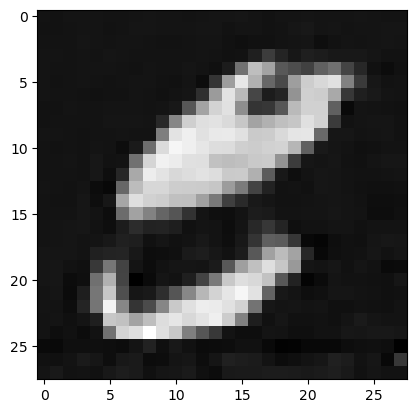

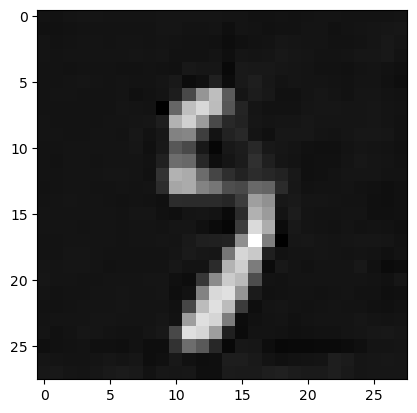

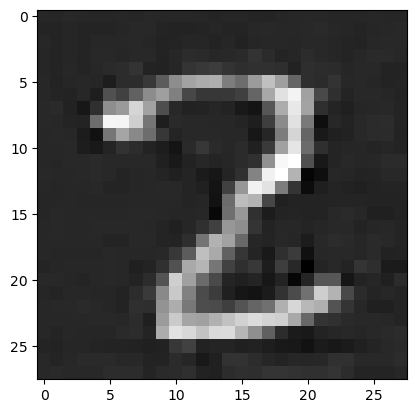

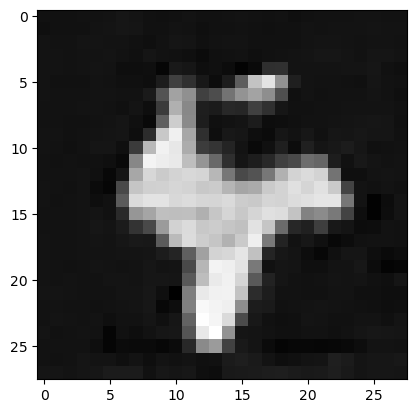

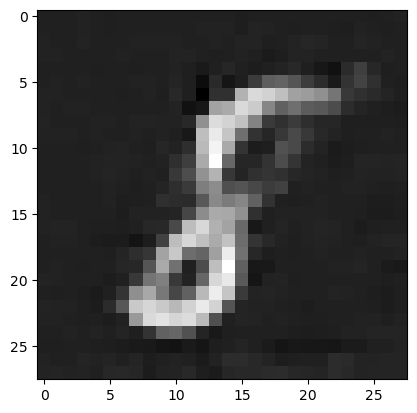

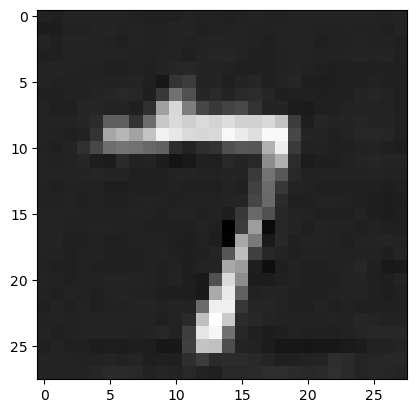

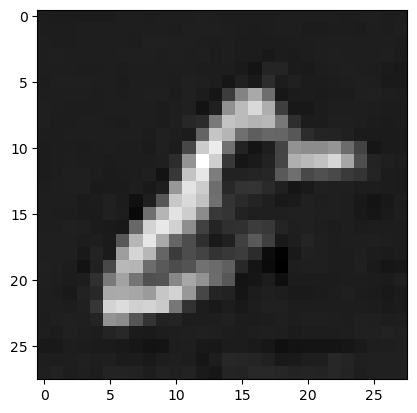

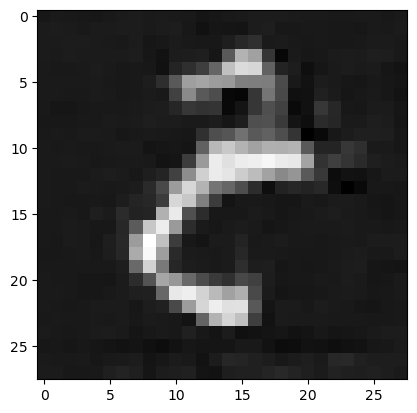

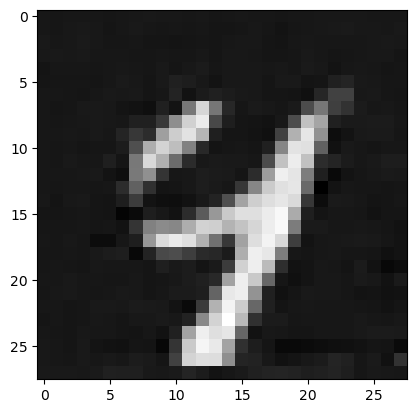

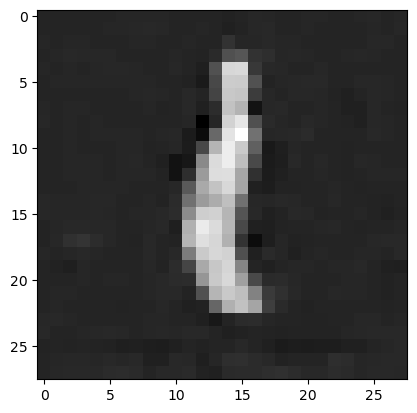

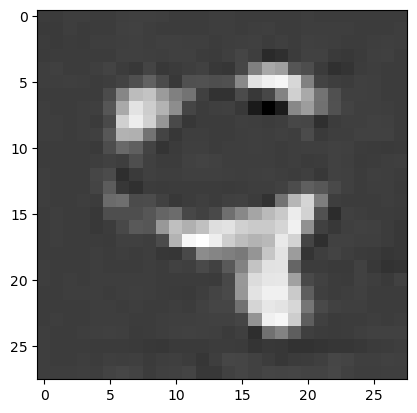

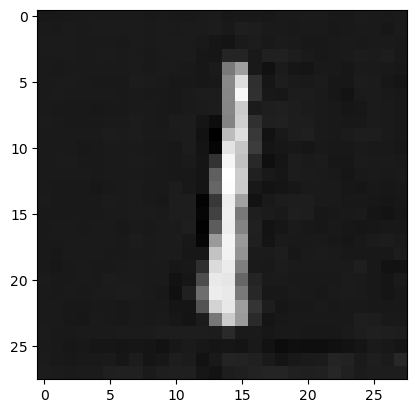

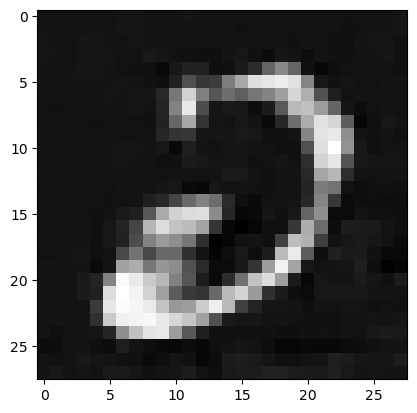

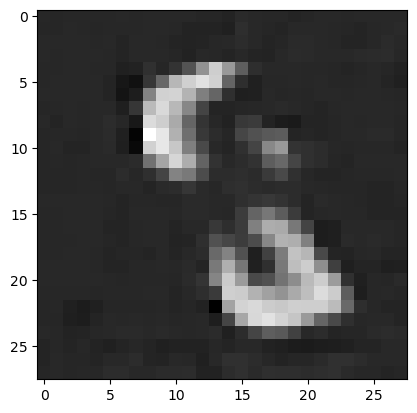

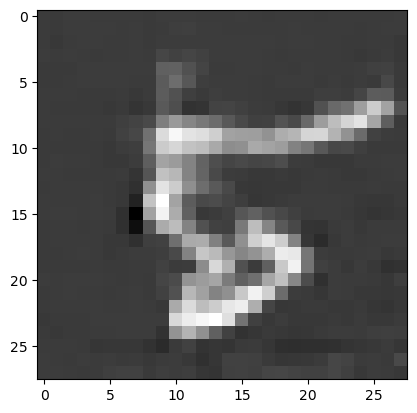

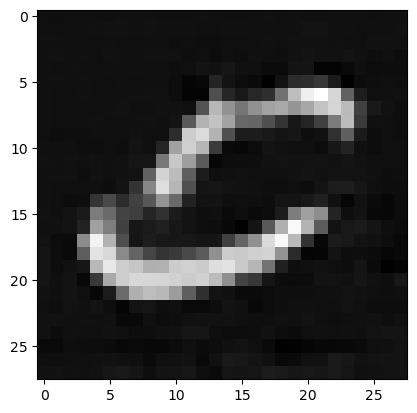

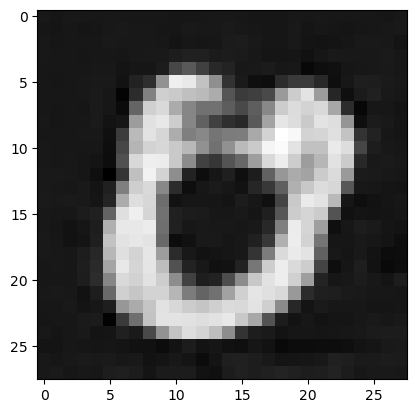

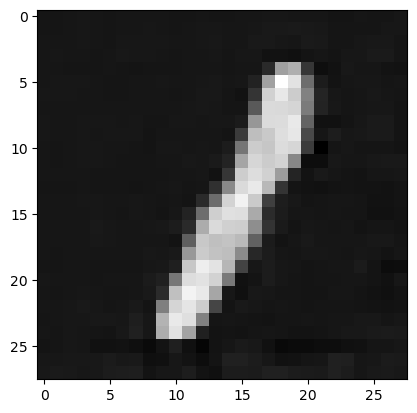

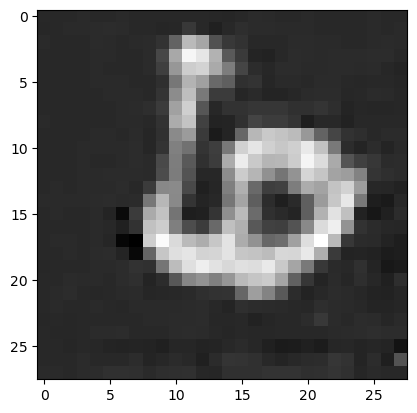

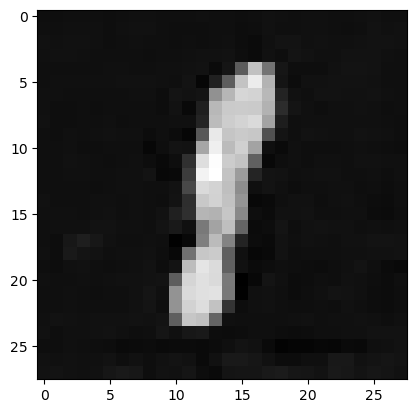

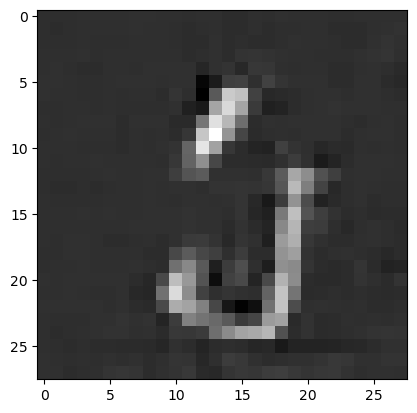

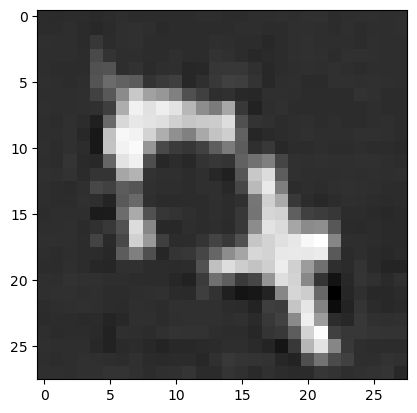

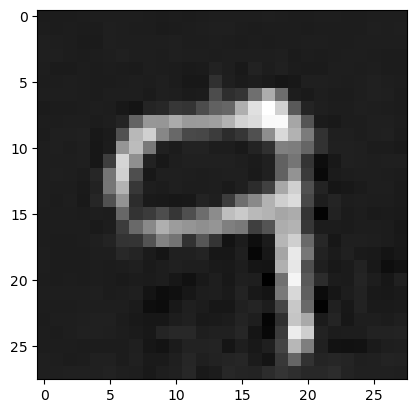

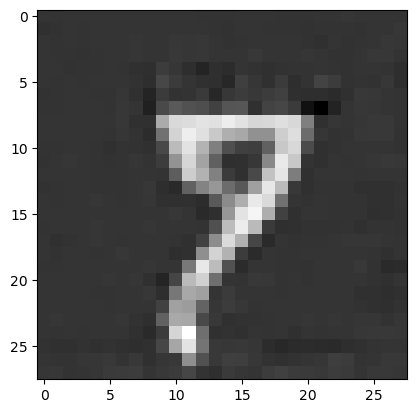

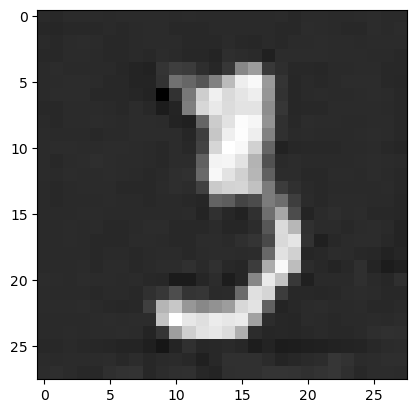

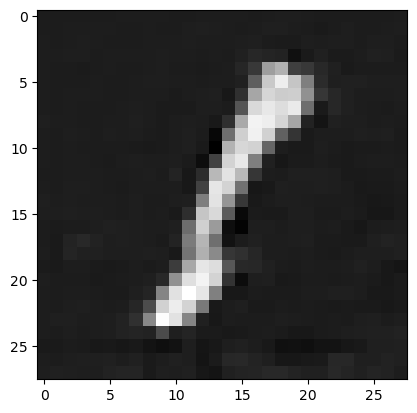

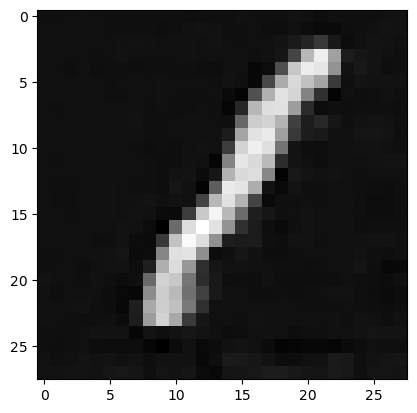

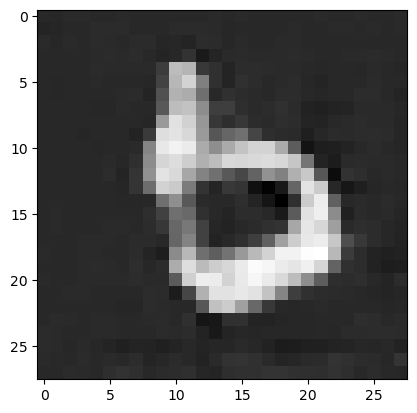

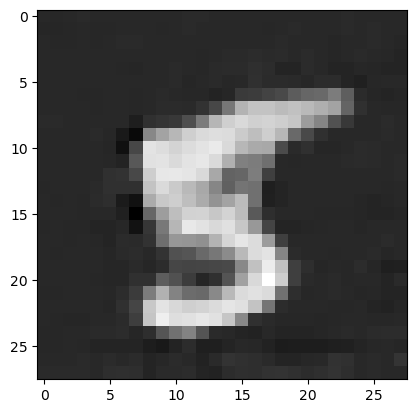

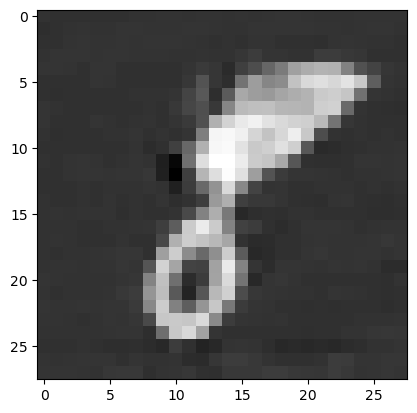

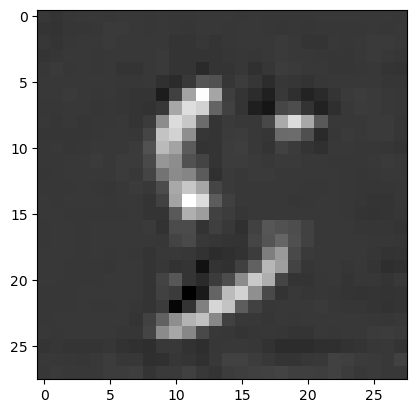

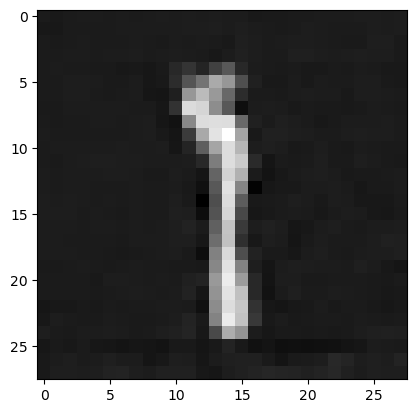

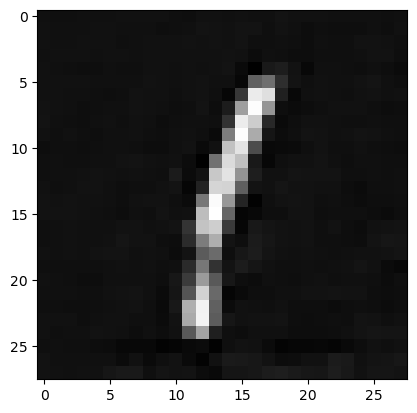

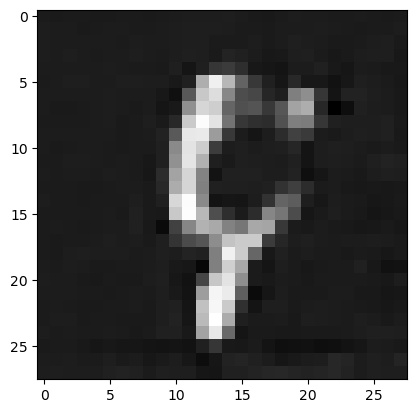

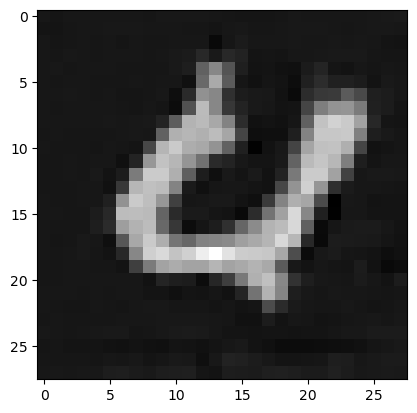

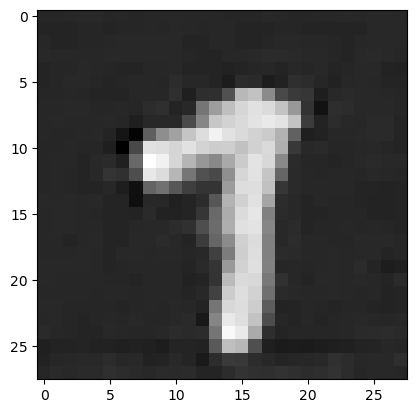

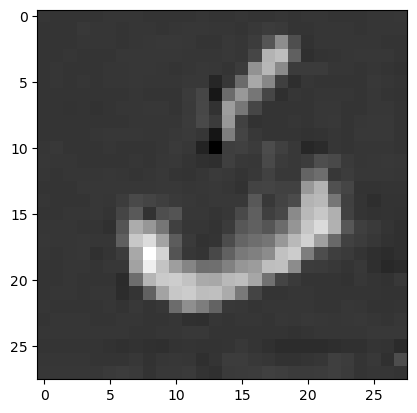

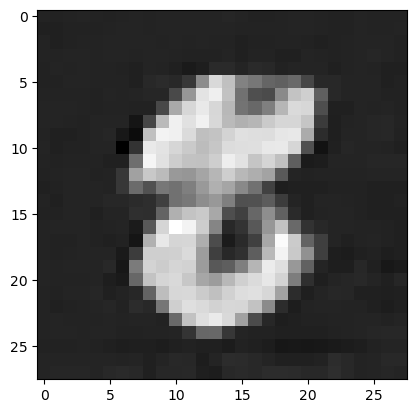

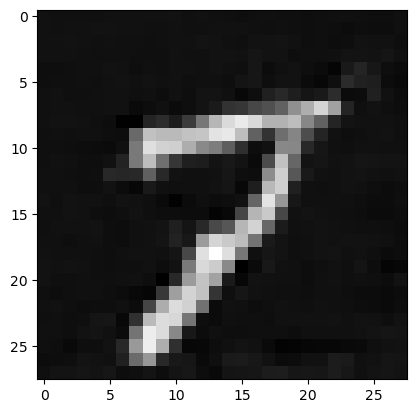

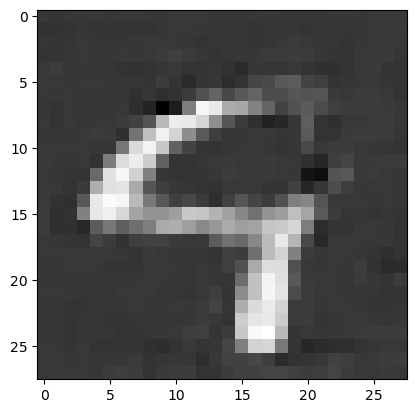

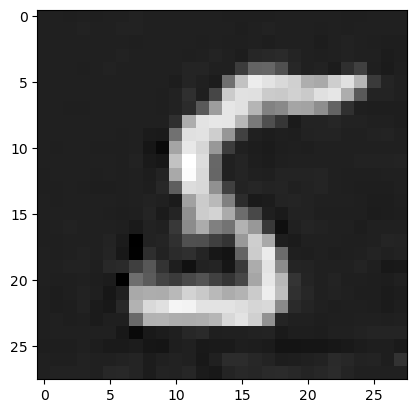

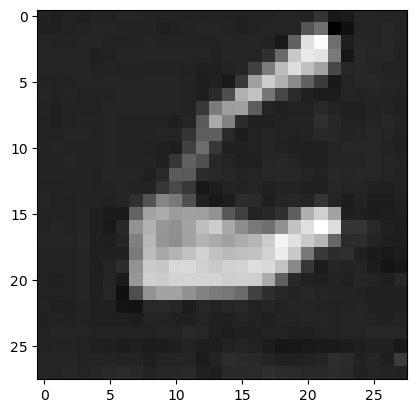

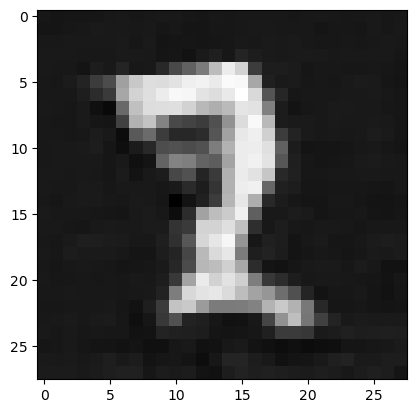

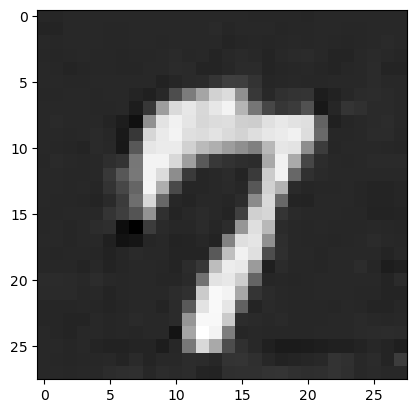

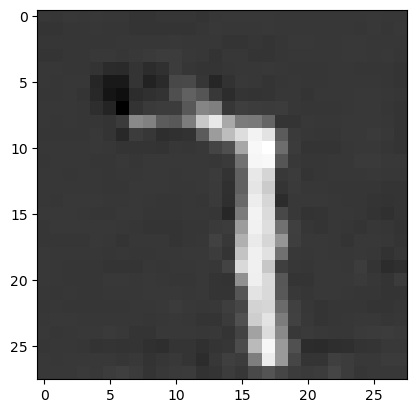

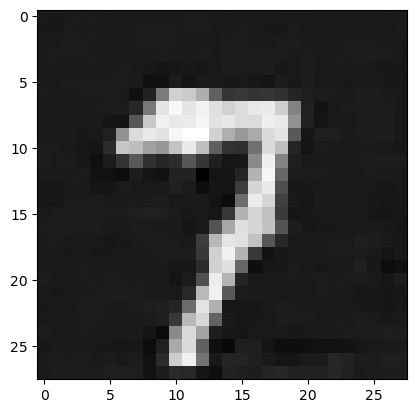

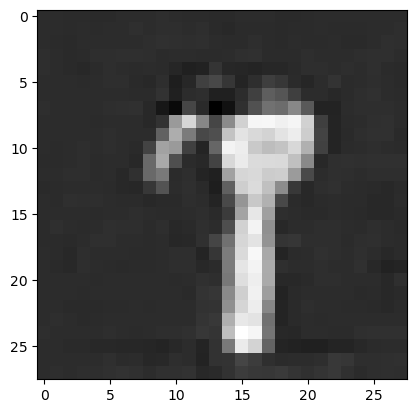

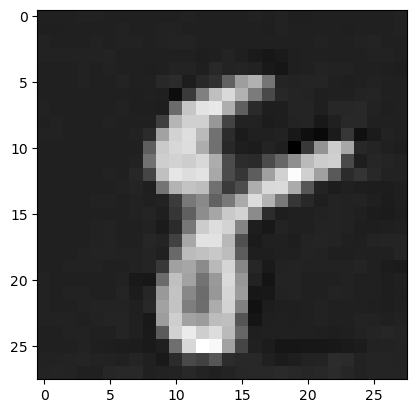

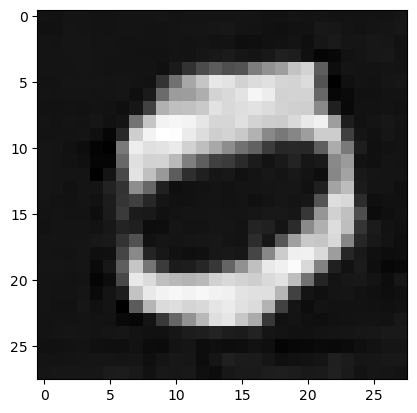

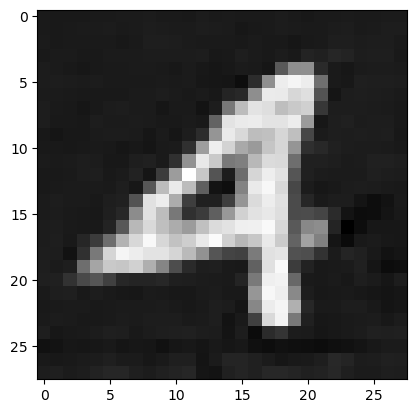

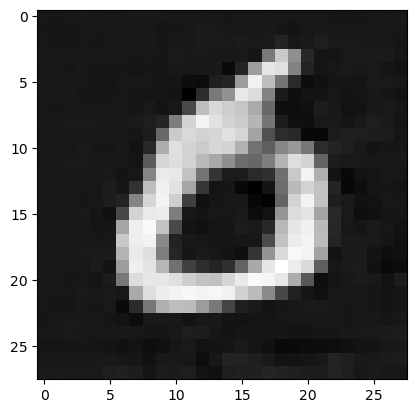

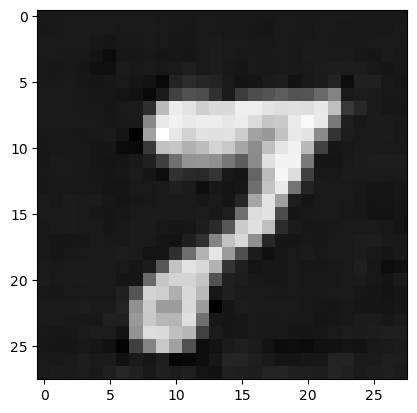

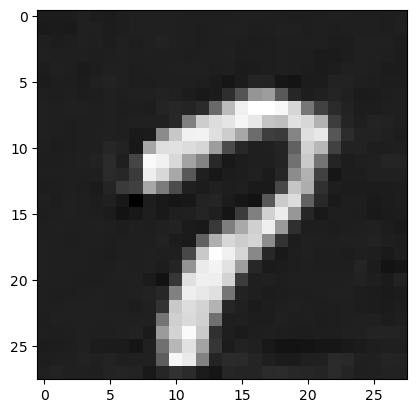

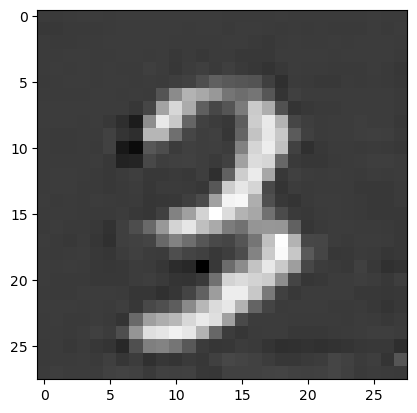

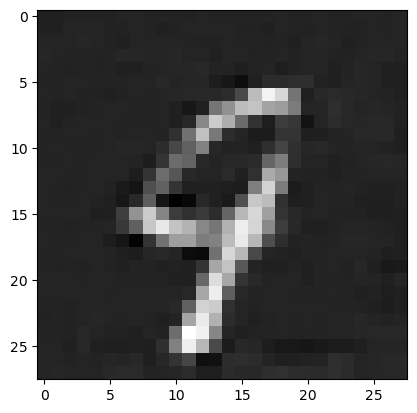

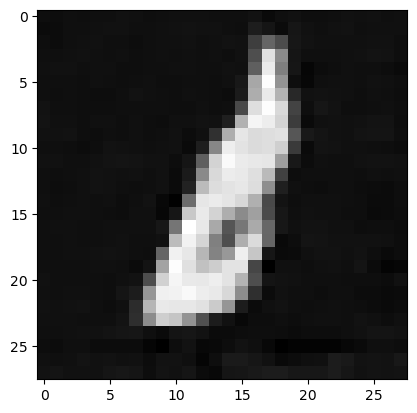

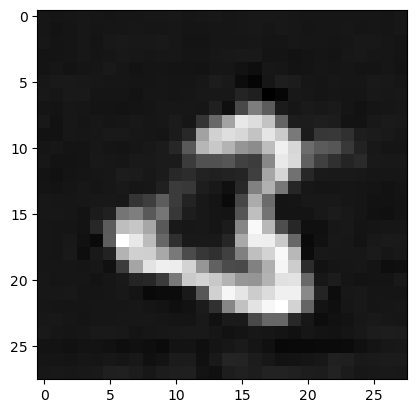

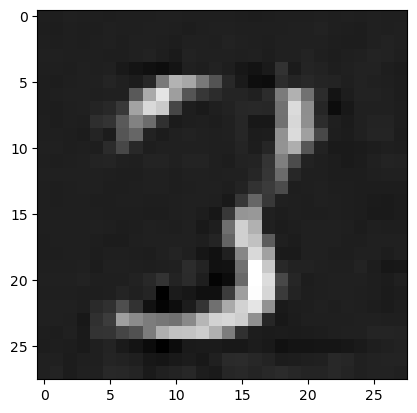

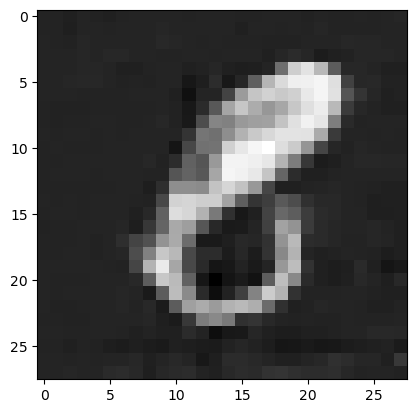

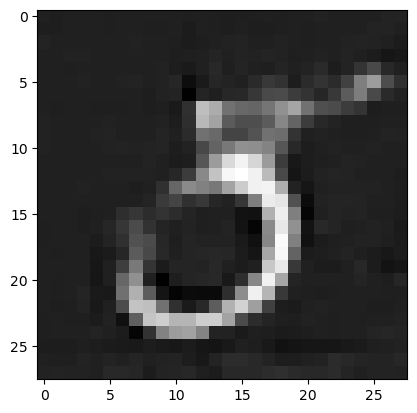

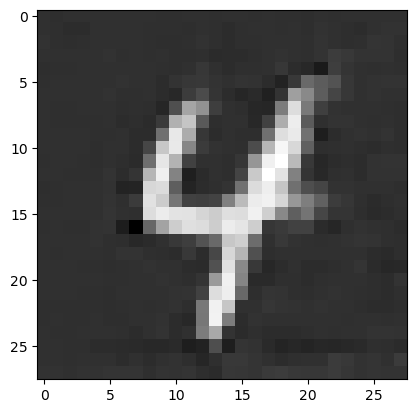

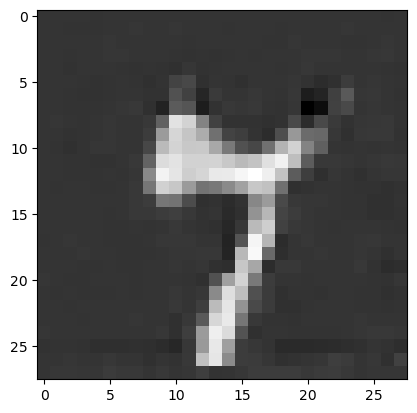

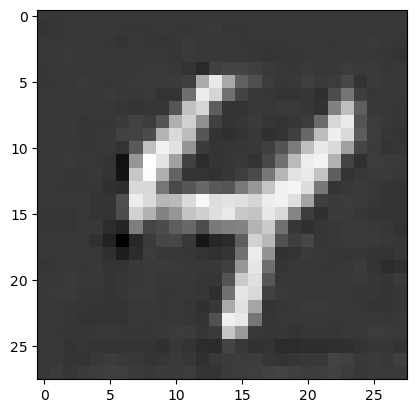

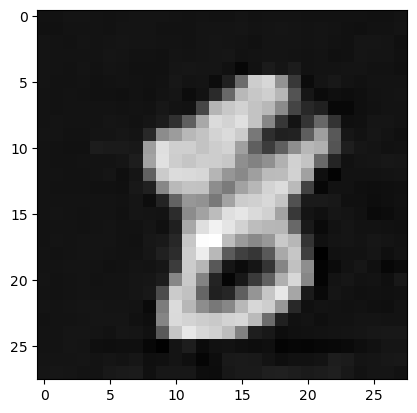

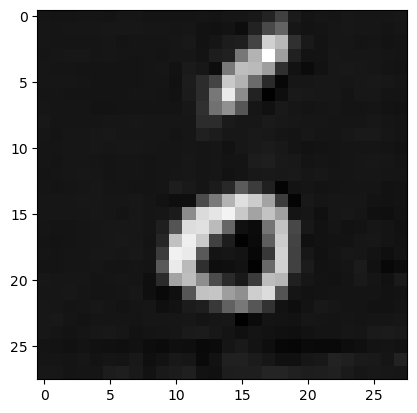

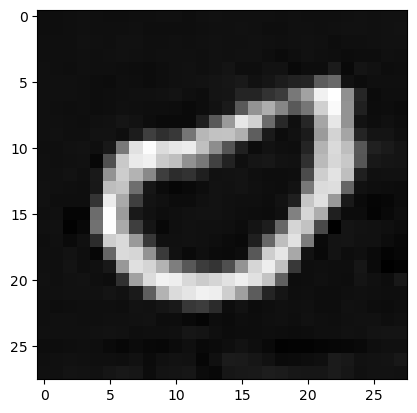

In [101]:
for i in range(len(vectors)):
    transformed = (vectors[i][0].cpu() + torch.tensor(np.random.randn(1, 144)*2)).float()
    plt.imshow(model((transformed.cuda()).cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')
    plt.show()

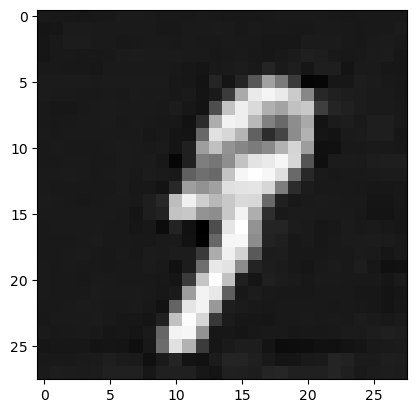

In [100]:
transformed = (vectors[12][0].cpu() + torch.tensor(np.random.randn(1, 144)*2)).float()
plt.imshow(model((transformed.cuda()).cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

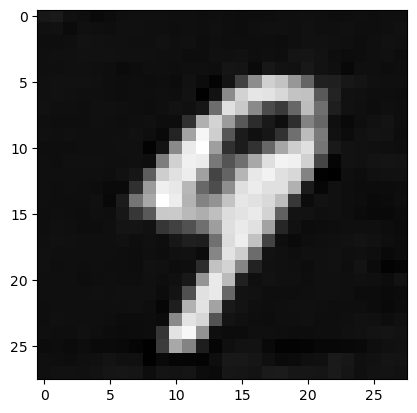

In [79]:
plt.imshow(model((vectors[12][0] + 1.2).cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

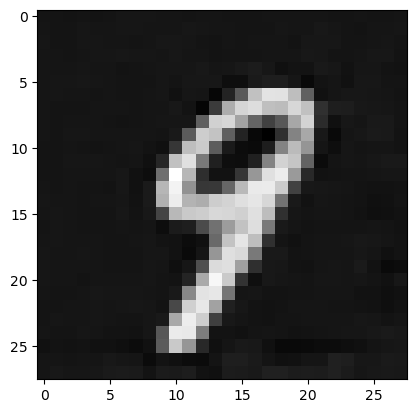

In [75]:
plt.imshow(model(vectors[12][0].cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

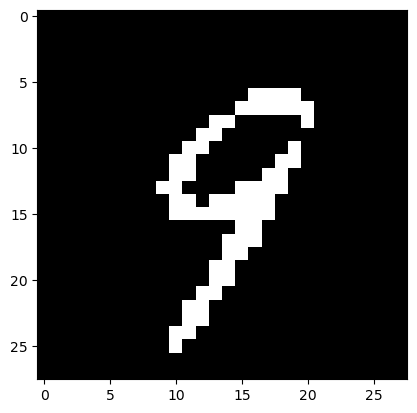

In [41]:
plt.imshow(model(img[12].cuda())[0].view(28,28).cpu().detach().numpy() > 0.5, cmap='gray', interpolation='none')

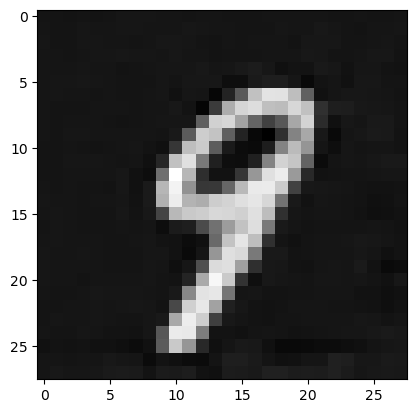

In [40]:
plt.imshow(model(img[12].cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

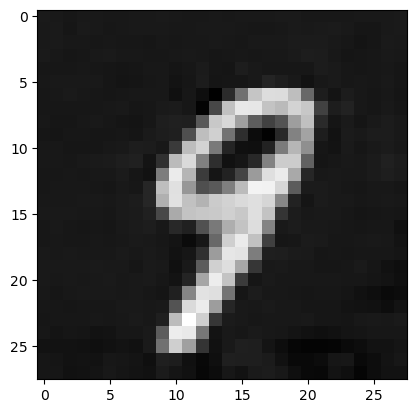

In [27]:
plt.imshow(model(img[12].cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

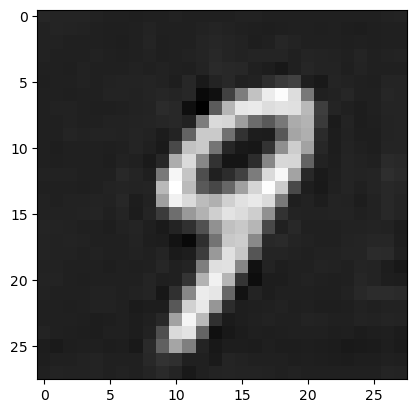

In [20]:
plt.imshow(model(img[12].cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

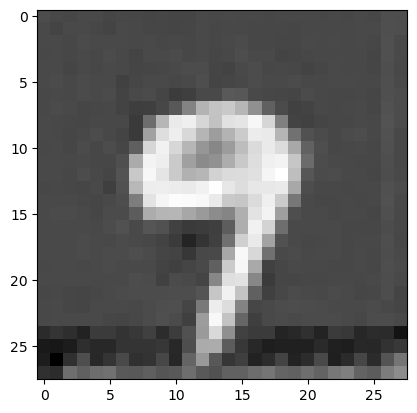

In [52]:
plt.imshow(model(img[12].cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

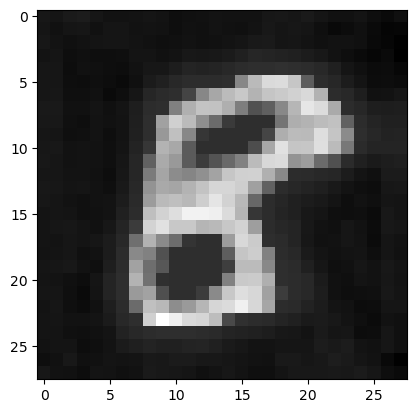

In [27]:
plt.imshow(model(img[0].cuda())[0].view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    encoded = ae.encoder(tf.expand_dims(test_image[i],axis=0))
    cleaned = ae.decoder(encoded)
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(test_image[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(cleaned))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')